In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('tmdb_5000_movies.csv')

print(f"\nDataset Shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

print(f"\nDataset Info:")
print(data.info())

print(f"\nColumn Names:")
print(data.columns.tolist())

print(f"\nStatistical Summary:")
print(data.describe())

print(f"\nMissing Values:")
missing = data.isnull().sum()
print(missing[missing > 0])

print(f"\nData Types:")
print(data.dtypes)

print(f"\nDuplicate Values:")
duplicate = data.duplicated().sum()
print(duplicate)


Dataset Shape: (4803, 20)

First few rows:
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na.

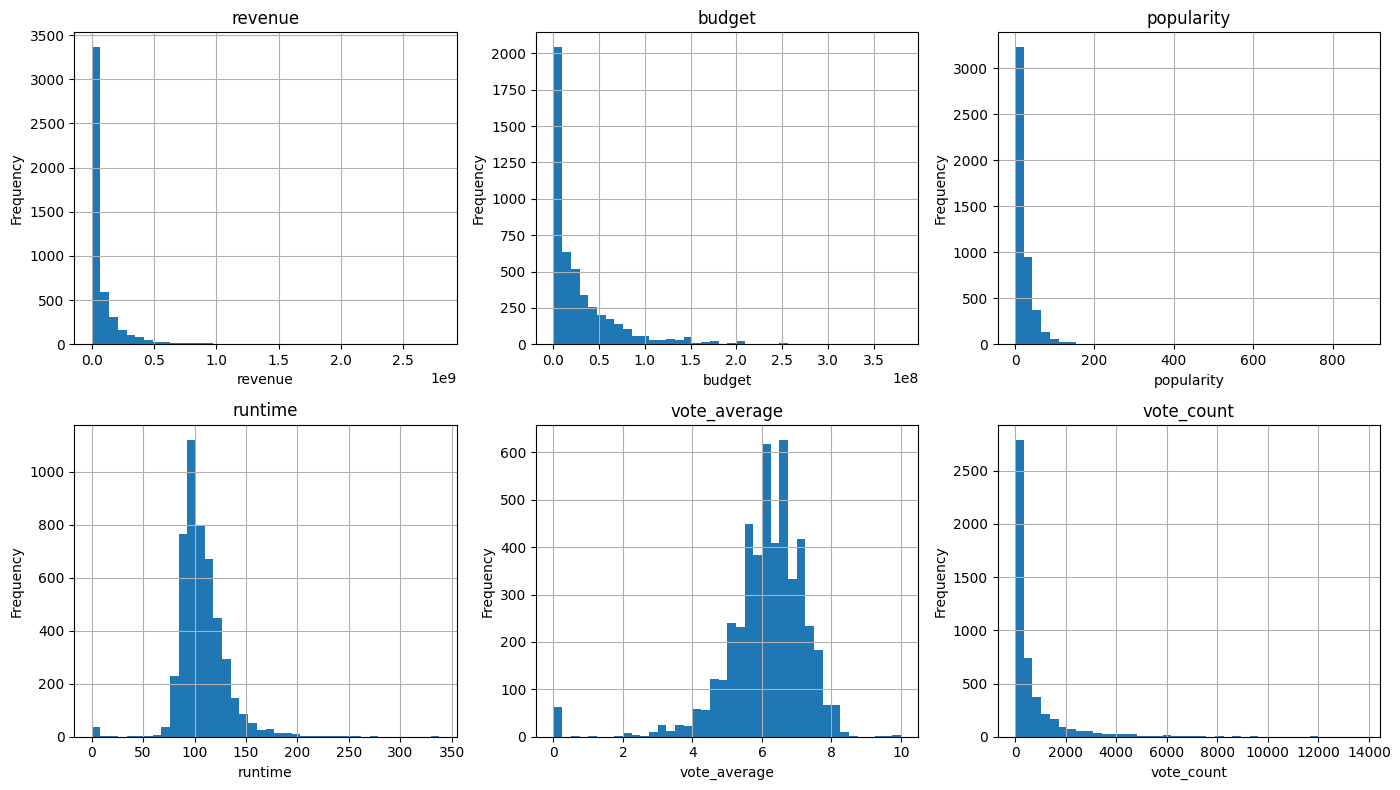

In [2]:
num_cols = ['revenue', 'budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    data[col].hist(bins=40)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

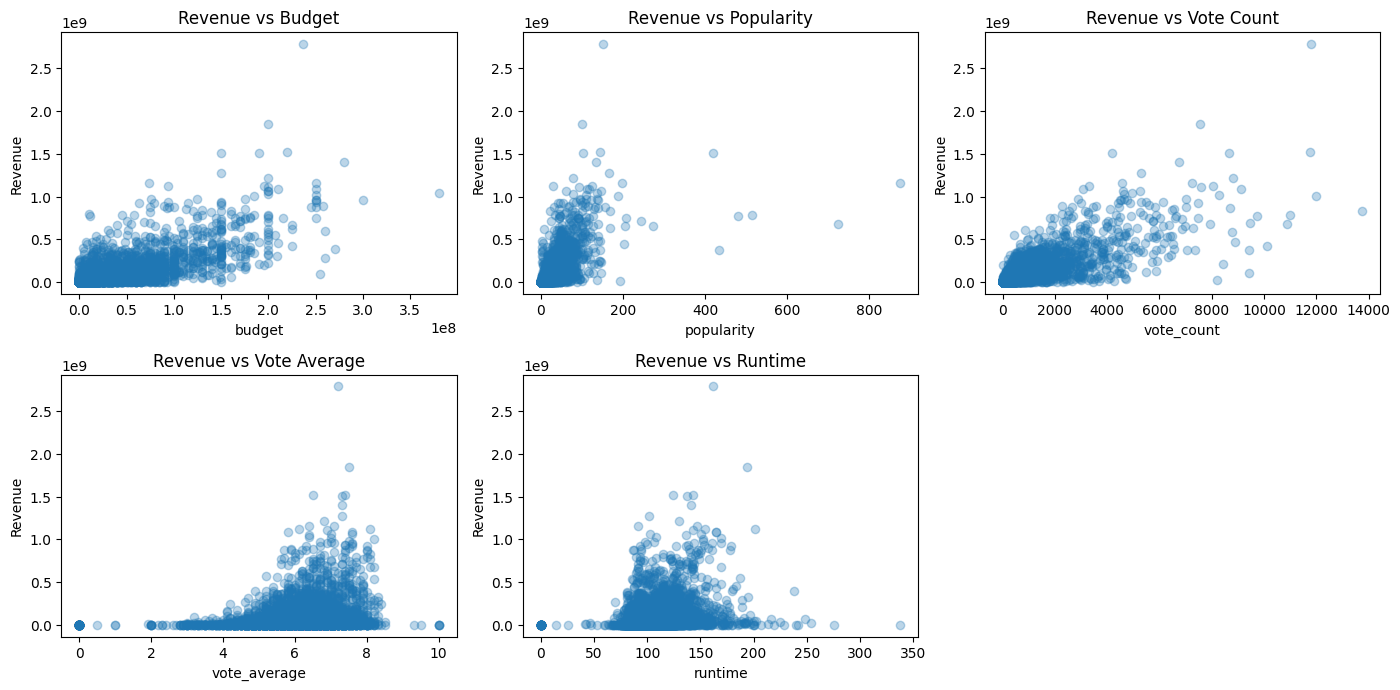

In [3]:
plt.figure(figsize=(14, 10))

candidates = ['budget', 'popularity', 'vote_count', 'vote_average', 'runtime']
titles = ['Budget', 'Popularity', 'Vote Count', 'Vote Average', 'Runtime']

for i, col in enumerate(candidates, 1):
    plt.subplot(3, 3, i)
    plt.scatter(data[col], data['revenue'], alpha=0.3)
    plt.xlabel(col)
    plt.ylabel('Revenue')
    plt.title(f'Revenue vs {titles[i-1]}')

plt.tight_layout()
plt.show()


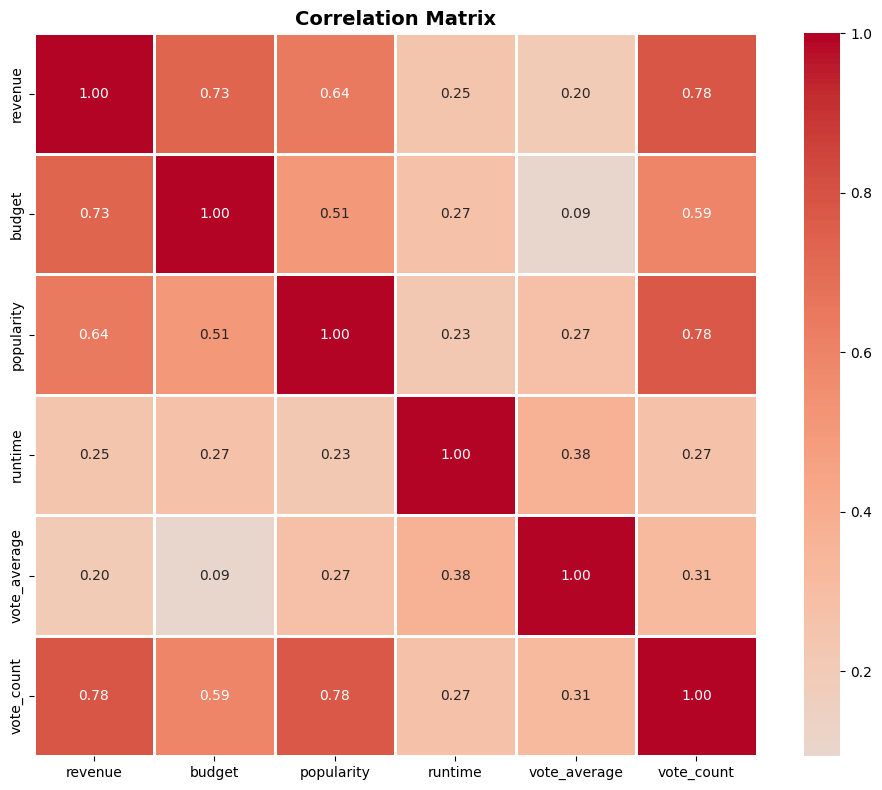


Correlation with Revenue:
revenue         1.000000
vote_count      0.781487
budget          0.730823
popularity      0.644724
runtime         0.251093
vote_average    0.197150
Name: revenue, dtype: float64


In [4]:
plt.figure(figsize=(10, 8))
corr = data[num_cols].corr()
sns.heatmap (corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with Revenue:")
print(corr['revenue'].sort_values(ascending=False))

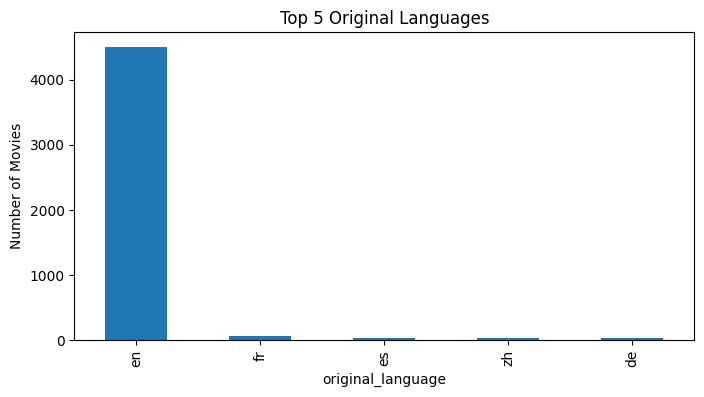

In [5]:
data['original_language'].value_counts().head(10)

data.groupby('original_language')['revenue'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
data['original_language'].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Original Languages')
plt.ylabel('Number of Movies')
plt.show()

In [6]:
data_cleaned = data.copy()

# Handle Target Variable (Revenue)
print(f"Non-zero revenue entries: {(data_cleaned['revenue'] > 0).sum()}")
print(f"Zero revenue entries: {(data_cleaned['revenue'] == 0).sum()}")

# Remove movies with zero or missing revenue (can't train on missing targets)
data_cleaned = data_cleaned[data_cleaned['revenue'] > 0]
print(f"✓ Removed movies with zero revenue")
print(f"New shape: {data_cleaned.shape}")

# Remove movies with zero budget (unreliable data)
data_cleaned = data_cleaned[data_cleaned['budget'] > 0]
print(f"✓ Removed movies with zero budget")
print(f"Final shape: {data_cleaned.shape}")

Non-zero revenue entries: 3376
Zero revenue entries: 1427
✓ Removed movies with zero revenue
New shape: (3376, 20)
✓ Removed movies with zero budget
Final shape: (3229, 20)


In [7]:
# Handle Missing Values
print(f"\nMissing values before handling:")
print(data_cleaned.isnull().sum()[data_cleaned.isnull().sum() > 0])

# Release date - drop rows with missing dates
data_cleaned = data_cleaned.dropna(subset=['release_date'])
print(f"Dropped {data.shape[0] - data_cleaned.shape[0]} rows with missing release_date")

# Runtime - impute with median
runtime_median = data_cleaned['runtime'].median()
data_cleaned['runtime'] = data_cleaned['runtime'].fillna(runtime_median)
print(f"Imputed runtime with median: {runtime_median}")

# Homepage - create binary feature
data_cleaned["has_homepage"] = (
    data_cleaned["homepage"].notna() & 
    (data_cleaned["homepage"].str.len() > 0)
).astype(int)
print(f"Created has_homepage feature")

# Tagline - create binary feature
data_cleaned["has_tagline"] = (
    data_cleaned["tagline"].notna() & 
    (data_cleaned["tagline"].str.strip().str.len() > 0)
).astype(int)
print(f"Created has_tagline feature")

# Overview - create binary feature
data_cleaned['has_overview'] = data_cleaned['overview'].notna().astype(int)
print(f"Created has_overview feature")

print(f"\nMissing values after handling:")
print(data_cleaned.isnull().sum()[data_cleaned.isnull().sum() > 0])


Missing values before handling:
homepage    1882
tagline      245
dtype: int64
Dropped 1574 rows with missing release_date
Imputed runtime with median: 107.0
Created has_homepage feature
Created has_tagline feature
Created has_overview feature

Missing values after handling:
homepage    1882
tagline      245
dtype: int64


Extracted release_year and release_month


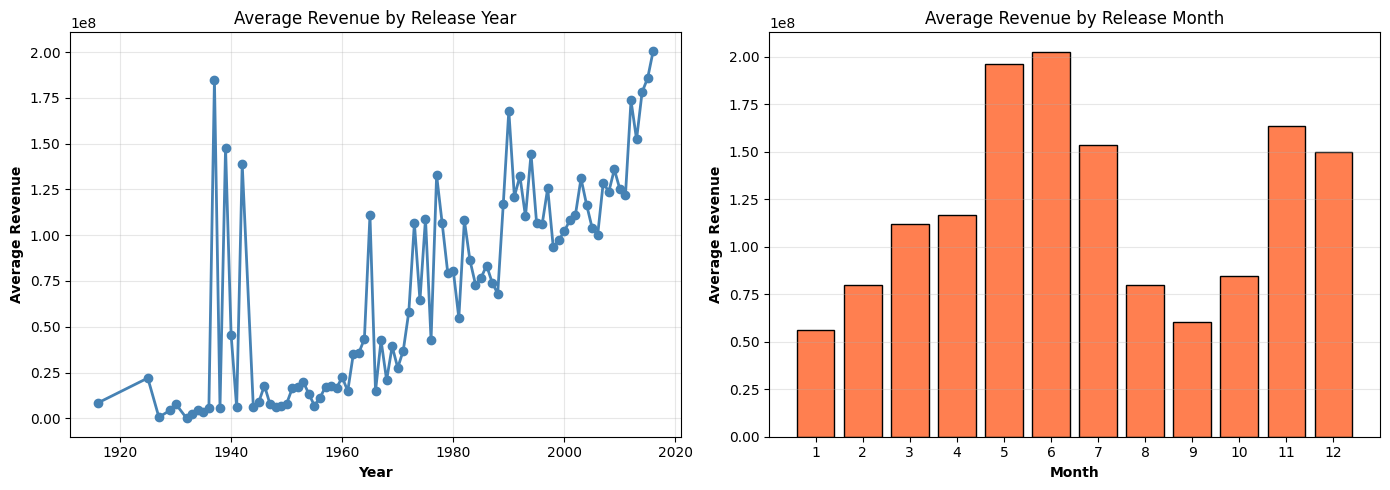

In [8]:
# Date Feature Extraction
data_cleaned["release_date"] = pd.to_datetime(data_cleaned["release_date"], errors="coerce")
data_cleaned["release_year"] = data_cleaned["release_date"].dt.year
data_cleaned["release_month"] = data_cleaned["release_date"].dt.month
print(f"Extracted release_year and release_month")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
yearly_revenue = data_cleaned.groupby('release_year')['revenue'].mean()
plt.plot(yearly_revenue.index, yearly_revenue.values, marker='o', linewidth=2, color='steelblue')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Revenue', fontweight='bold')
plt.title('Average Revenue by Release Year')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
monthly_revenue = data_cleaned.groupby('release_month')['revenue'].mean()
plt.bar(monthly_revenue.index, monthly_revenue.values, color='coral', edgecolor='black')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Average Revenue', fontweight='bold')
plt.title('Average Revenue by Release Month')
plt.xticks(range(1, 13))
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [9]:
# Parse JSON Columns
data_processed = data_cleaned.copy()

def safe_parse_json(x):
    try:
        if pd.isna(x) or x == '':
            return []
        return json.loads(x.replace("'", '"'))
    except:
        try:
            return ast.literal_eval(x)
        except:
            return []

# Parse genres
print(" Parsing genres...")
data_processed['genres_list'] = data_processed['genres'].apply(safe_parse_json)
data_processed['num_genres'] = data_processed['genres_list'].apply(len)

def extract_genre_names(genres_list):
    return [g['name'] for g in genres_list if isinstance(g, dict) and 'name' in g]

data_processed['genre_names'] = data_processed['genres_list'].apply(extract_genre_names)

# Create binary columns for top genres
all_genres = []
for genres in data_processed['genre_names']:
    all_genres.extend(genres)

top_genres = pd.Series(all_genres).value_counts().head(10).index.tolist()
print(f"  Top 10 genres: {top_genres}")

for genre in top_genres:
    data_processed[f'genre_{genre}'] = data_processed['genre_names'].apply(
        lambda x: 1 if genre in x else 0
    )
print(f"Created {len(top_genres)} genre binary features")

# Parse keywords
print("Parsing keywords...")
data_processed['keywords_list'] = data_processed['keywords'].apply(safe_parse_json)
data_processed['num_keywords'] = data_processed['keywords_list'].apply(len)
print("Extracted keyword count")

# Parse production companies
print("Parsing production companies...")
data_processed['companies_list'] = data_processed['production_companies'].apply(safe_parse_json)
data_processed['num_companies'] = data_processed['companies_list'].apply(len)
print("Extracted production company count")

# Parse production countries
print("Parsing production countries...")
data_processed['countries_list'] = data_processed['production_countries'].apply(safe_parse_json)
data_processed['num_countries'] = data_processed['countries_list'].apply(len)
print("Extracted production country count")

# Parse spoken languages
print("Parsing spoken languages...")
data_processed['languages_list'] = data_processed['spoken_languages'].apply(safe_parse_json)
data_processed['num_languages'] = data_processed['languages_list'].apply(len)
print("Extracted spoken language count")


 Parsing genres...
  Top 10 genres: ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Family', 'Fantasy']
Created 10 genre binary features
Parsing keywords...
Extracted keyword count
Parsing production companies...
Extracted production company count
Parsing production countries...
Extracted production country count
Parsing spoken languages...
Extracted spoken language count


In [10]:
# outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_cols = ['budget', 'popularity', 'runtime', 'vote_count']
for col in outlier_cols:
    outliers, lb, ub = detect_outliers_iqr(data_processed, col)
    print(f"  {col}: {len(outliers)} outliers ({len(outliers)/len(data_processed)*100:.2f}%)")


  budget: 216 outliers (6.69%)
  popularity: 175 outliers (5.42%)
  runtime: 99 outliers (3.07%)
  vote_count: 305 outliers (9.45%)


In [11]:
# feature engineering
# budget-related features
data_processed['budget_log'] = np.log1p(data_processed['budget'])
data_processed['budget_per_company'] = data_processed['budget'] / (data_processed['num_companies'] + 1)
print("budget_log, budget_per_company")

# popularity features
data_processed['popularity_log'] = np.log1p(data_processed['popularity'])
data_processed['popularity_squared'] = data_processed['popularity'] ** 2
print("popularity_log, popularity_squared")

# Vote features
data_processed['vote_count_log'] = np.log1p(data_processed['vote_count'])
data_processed['vote_density'] = data_processed['vote_count'] / (data_processed['popularity'] + 1)
data_processed['vote_score'] = data_processed['vote_average'] * np.log1p(data_processed['vote_count'])
print("vote_count_log, vote_density, vote_score")

# runtime features
data_processed['is_long_movie'] = (data_processed['runtime'] > 120).astype(int)
data_processed['is_short_movie'] = (data_processed['runtime'] < 90).astype(int)
data_processed['runtime_squared'] = data_processed['runtime'] ** 2
print("is_long_movie, is_short_movie, runtime_squared")

# temporal features
data_processed['years_since_release'] = 2024 - data_processed['release_year']
data_processed['is_recent'] = (data_processed['release_year'] >= 2010).astype(int)
data_processed['decade'] = (data_processed['release_year'] // 10) * 10

def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

data_processed['release_season'] = data_processed['release_month'].apply(get_season)
print("years_since_release, is_recent, decade, release_season")

budget_log, budget_per_company
popularity_log, popularity_squared
vote_count_log, vote_density, vote_score
is_long_movie, is_short_movie, runtime_squared
years_since_release, is_recent, decade, release_season


In [12]:
# interaction features
data_processed['budget_popularity'] = data_processed['budget'] * data_processed['popularity']
data_processed['budget_vote_count'] = data_processed['budget'] * data_processed['vote_count']
data_processed['popularity_vote_avg'] = data_processed['popularity'] * data_processed['vote_average']
print("budget_popularity, budget_vote_count, popularity_vote_avg")

# language encoding
language_counts = data_processed['original_language'].value_counts()
top_languages = language_counts[language_counts >= 10].index.tolist()
data_processed['language_group'] = data_processed['original_language'].apply(
    lambda x: x if x in top_languages else 'other'
)

language_dummies = pd.get_dummies(data_processed['language_group'], prefix='lang')
data_processed = pd.concat([data_processed, language_dummies], axis=1)
print(f"Created {len(language_dummies.columns)} language features")

# complexity score
data_processed['complexity_score'] = (
    data_processed['num_genres'] * 0.2 +
    data_processed['num_keywords'] * 0.3 +
    data_processed['num_companies'] * 0.3 +
    data_processed['num_countries'] * 0.1 +
    data_processed['num_languages'] * 0.1
)
print("complexity_score")

# ROI potential features
data_processed['budget_efficiency'] = data_processed['vote_count'] / (data_processed['budget'] / 1e6 + 1)
data_processed['marketing_indicator'] = data_processed['popularity'] / (data_processed['budget'] / 1e6 + 1)
print(" budget_efficiency, marketing_indicator")

print(f"\nFeature engineering complete!")
print(f"Total columns after feature engineering: {data_processed.shape[1]}")

budget_popularity, budget_vote_count, popularity_vote_avg
Created 6 language features
complexity_score
 budget_efficiency, marketing_indicator

Feature engineering complete!
Total columns after feature engineering: 73


In [72]:
data_processed.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 73 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   budget                 3229 non-null   int64         
 1   genres                 3229 non-null   object        
 2   homepage               1347 non-null   object        
 3   id                     3229 non-null   int64         
 4   keywords               3229 non-null   object        
 5   original_language      3229 non-null   object        
 6   original_title         3229 non-null   object        
 7   overview               3229 non-null   object        
 8   popularity             3229 non-null   float64       
 9   production_companies   3229 non-null   object        
 10  production_countries   3229 non-null   object        
 11  release_date           3229 non-null   datetime64[ns]
 12  revenue                3229 non-null   int64         
 13  runtime 

In [13]:
# select features
exclude_cols = ['id', 'budget', 'genres', 'homepage', 'keywords', 'original_language',
                'original_title', 'overview', 'popularity', 'production_companies',
                'production_countries', 'release_date', 'spoken_languages', 'status',
                'tagline', 'title', 'vote_average', 'vote_count', 'runtime',
                'genres_list', 'genre_names', 'keywords_list', 'companies_list',
                'countries_list', 'languages_list', 'language_group', 'revenue']

# Keep numeric and engineered features
feature_cols = [col for col in data_processed.columns if col not in exclude_cols]

# Add back important original features
important_original = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
for col in important_original:
    if col not in feature_cols and col != 'revenue':
        feature_cols.append(col)

X = data_processed[feature_cols]
y = data_processed['revenue']

print(f"  Features selected: {len(feature_cols)}")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Handle remaining NaN and infinite values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)
print("Handled NaN and infinite values")

  Features selected: 51
  X shape: (3229, 51)
  y shape: (3229,)
Handled NaN and infinite values


In [78]:
print(feature_cols)

['has_homepage', 'has_tagline', 'has_overview', 'release_year', 'release_month', 'num_genres', 'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action', 'genre_Adventure', 'genre_Romance', 'genre_Crime', 'genre_Science Fiction', 'genre_Family', 'genre_Fantasy', 'num_keywords', 'num_companies', 'num_countries', 'num_languages', 'budget_log', 'budget_per_company', 'popularity_log', 'popularity_squared', 'vote_count_log', 'vote_density', 'vote_score', 'is_long_movie', 'is_short_movie', 'runtime_squared', 'years_since_release', 'is_recent', 'decade', 'release_season', 'budget_popularity', 'budget_vote_count', 'popularity_vote_avg', 'lang_en', 'lang_es', 'lang_fr', 'lang_ja', 'lang_other', 'lang_zh', 'complexity_score', 'budget_efficiency', 'marketing_indicator', 'budget', 'popularity', 'runtime', 'vote_average', 'vote_count']


In [80]:
# Train-Test Split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"  Train set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")


  Train set: (2583, 51)
  Test set: (646, 51)


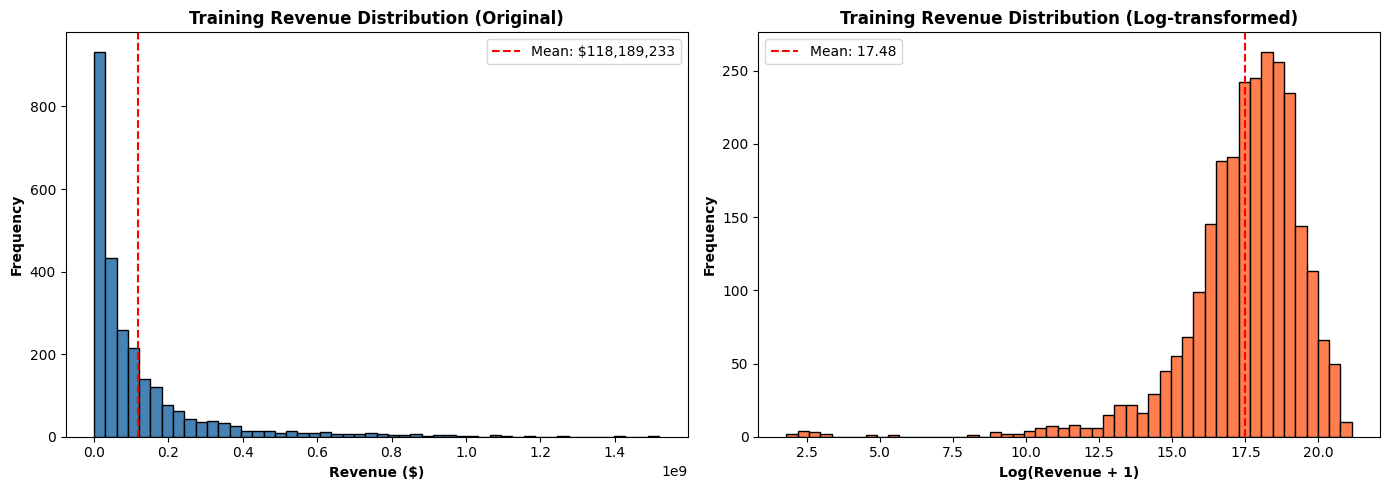


Revenue statistics:
  Original - Mean: $118,189,232.76, Median: $54,667,954.00
  Log - Mean: 17.48, Median: 17.82
  Skewness reduced from 3.06 to -2.45


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original revenue distribution
axes[0].hist(y_train, bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Revenue ($)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Training Revenue Distribution (Original)', fontweight='bold')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
axes[0].legend()

# Log-transformed revenue distribution
axes[1].hist(y_train_log, bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Log(Revenue + 1)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Training Revenue Distribution (Log-transformed)', fontweight='bold')
axes[1].axvline(y_train_log.mean(), color='red', linestyle='--', label=f'Mean: {y_train_log.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nRevenue statistics:")
print(f"  Original - Mean: ${y_train.mean():,.2f}, Median: ${y_train.median():,.2f}")
print(f"  Log - Mean: {y_train_log.mean():.2f}, Median: {y_train_log.median():.2f}")
print(f"  Skewness reduced from {y_train.skew():.2f} to {y_train_log.skew():.2f}")


1. Original Revenue:
   Mean: $118,189,232.76
   Median: $54,667,954.00
   Skewness: 3.06
   Range: $5 - $1,519,557,910

2. Log Transformation [log1p(x)]:
   Mean: 17.48
   Median: 17.82
   Skewness: -2.45
   Range: 1.79 - 21.14

3. Square Root Transformation [sqrt(x)]:
   Mean: 8791.71
   Median: 7393.78
   Skewness: 1.27
   Range: 2.24 - 38981.51

4. Yeo-Johnson Transformation (Optimal Power):
   Lambda: 0.2060
   Mean: 185.92
   Median: 185.62
   Skewness: -0.01
   Range: 2.17 - 372.91


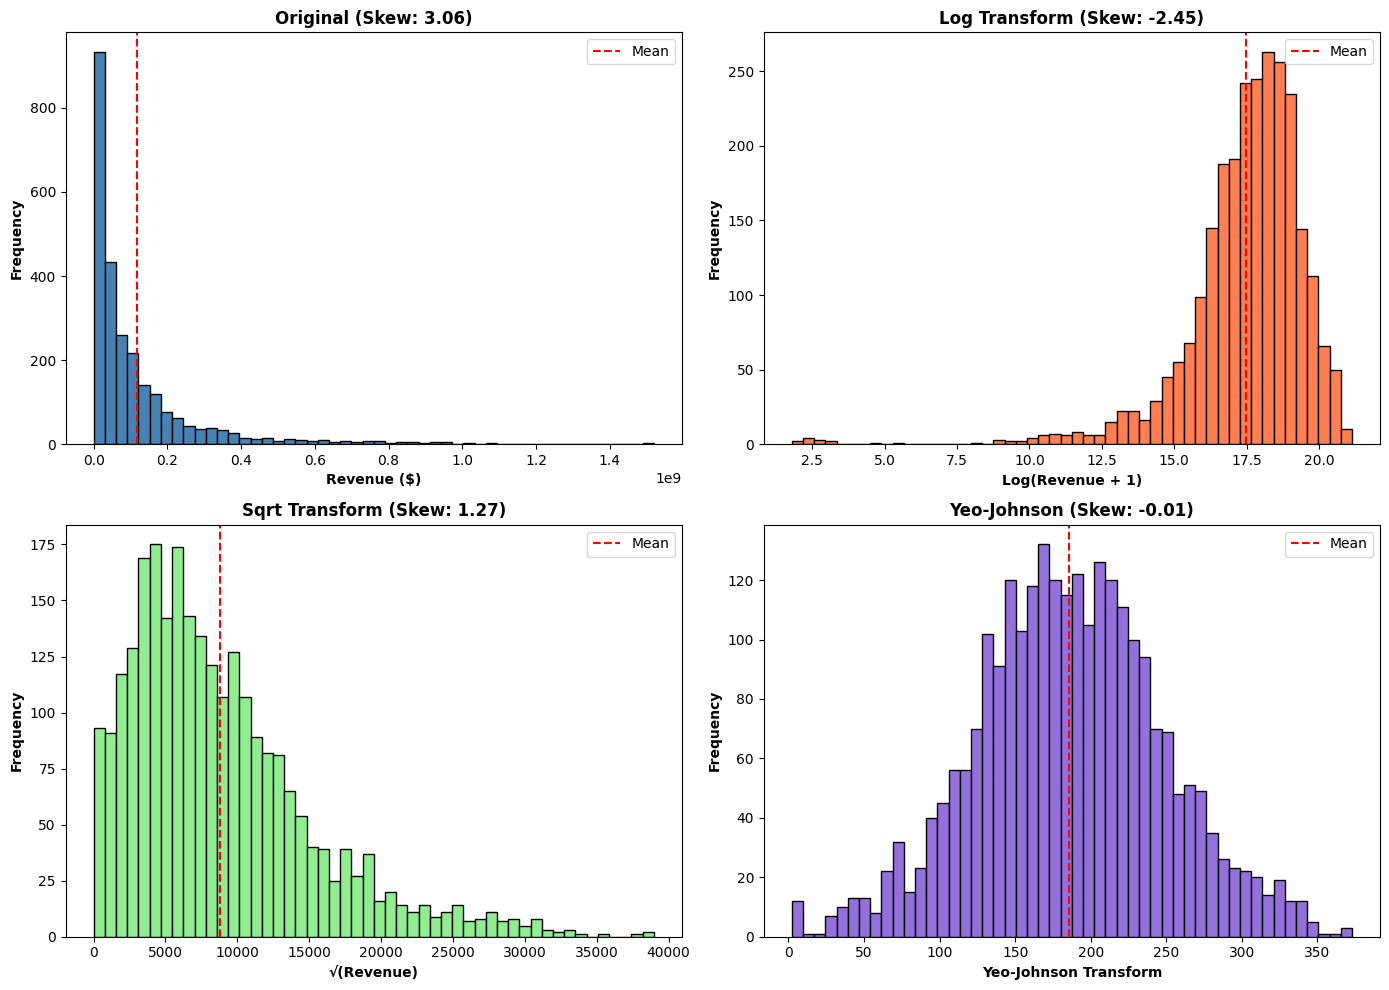

In [62]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Original
print(f"\n1. Original Revenue:")
print(f"   Mean: ${y_train.mean():,.2f}")
print(f"   Median: ${y_train.median():,.2f}")
print(f"   Skewness: {y_train.skew():.2f}")
print(f"   Range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")

# Log transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
print(f"\n2. Log Transformation [log1p(x)]:")
print(f"   Mean: {y_train_log.mean():.2f}")
print(f"   Median: {y_train_log.median():.2f}")
print(f"   Skewness: {y_train_log.skew():.2f}")
print(f"   Range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")

# Square root transformation
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)
print(f"\n3. Square Root Transformation [sqrt(x)]:")
print(f"   Mean: {y_train_sqrt.mean():.2f}")
print(f"   Median: {y_train_sqrt.median():.2f}")
print(f"   Skewness: {y_train_sqrt.skew():.2f}")
print(f"   Range: {y_train_sqrt.min():.2f} - {y_train_sqrt.max():.2f}")

# Yeo-Johnson transformation
pt_yeo = PowerTransformer(method='yeo-johnson', standardize=False)
y_train_yeo = pt_yeo.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_yeo = pt_yeo.transform(y_test.values.reshape(-1, 1)).flatten()
print(f"\n4. Yeo-Johnson Transformation (Optimal Power):")
print(f"   Lambda: {pt_yeo.lambdas_[0]:.4f}")
print(f"   Mean: {y_train_yeo.mean():.2f}")
print(f"   Median: {np.median(y_train_yeo):.2f}")
print(f"   Skewness: {pd.Series(y_train_yeo).skew():.2f}")
print(f"   Range: {y_train_yeo.min():.2f} - {y_train_yeo.max():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Original
axes[0, 0].hist(y_train, bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Revenue ($)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title(f'Original (Skew: {y_train.skew():.2f})', fontweight='bold')
axes[0, 0].axvline(y_train.mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Log
axes[0, 1].hist(y_train_log, bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Log(Revenue + 1)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title(f'Log Transform (Skew: {y_train_log.skew():.2f})', fontweight='bold')
axes[0, 1].axvline(y_train_log.mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Square Root
axes[1, 0].hist(y_train_sqrt, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('√(Revenue)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title(f'Sqrt Transform (Skew: {y_train_sqrt.skew():.2f})', fontweight='bold')
axes[1, 0].axvline(y_train_sqrt.mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].legend()

# Yeo-Johnson
axes[1, 1].hist(y_train_yeo, bins=50, color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Yeo-Johnson Transform', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title(f'Yeo-Johnson (Skew: {pd.Series(y_train_yeo).skew():.2f})', fontweight='bold')
axes[1, 1].axvline(y_train_yeo.mean(), color='red', linestyle='--', label='Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [82]:
# yeo transform target variable
y_train_yeo = pt_yeo.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_yeo = pt_yeo.transform(y_test.values.reshape(-1, 1)).flatten()

# feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled using StandardScaler")

# Store feature names
feature_names = X.columns.tolist()
print(f"  Total features: {len(feature_names)}")

 Features scaled using StandardScaler
  Total features: 51


In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# regressors
regressors_to_run = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Support Vector Regression': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'XGBoost': XGBRegressor()
}

model_performance = {}

for model_name, model in regressors_to_run.items():
    model.fit(X_train_scaled, y_train_yeo)

    y_pred_yeo = model.predict(X_test_scaled)

    mse_yeo = mean_squared_error(y_test_yeo, y_pred_yeo)
    rmse_yeo = np.sqrt(mse_yeo)
    r2_yeo = r2_score(y_test_yeo, y_pred_yeo)

    y_true = pt_yeo.inverse_transform(y_test_yeo.reshape(-1, 1)).ravel()
    y_pred = pt_yeo.inverse_transform(np.array(y_pred_yeo).reshape(-1, 1)).ravel()

    mse_dollar = mean_squared_error(y_true, y_pred)
    rmse_dollar = np.sqrt(mse_dollar)

    r2_dollar =r2_score(y_true, y_pred)

    model_performance[model_name] = {
        'RMSE_yeo': rmse_yeo,
        'R2_yeo': r2_yeo,
        'RMSE_dollar': rmse_dollar,
        'r2_dollar': r2_dollar,
        
    }

print("Model Evaluation Complete")
for name, m in model_performance.items():
    print(
        f"\n{name}: "
        f"\nRMSE_yeo = {m['RMSE_yeo']:.3f}, "
        f"\nR2_yeo = {m['R2_yeo']:.3f}, "
        f"\nRMSE_$ = {m['RMSE_dollar']:,.0f}"
        f"\nR2_$ = {m['r2_dollar']:,.3f}"
    )


--- Model Evaluation Complete ---

Linear Regression: 
RMSE_yeo = 32.907, 
R2_yeo = 0.746, 
RMSE_$ = 120,322,146
R2_$ = 0.714

Ridge Regression: 
RMSE_yeo = 32.898, 
R2_yeo = 0.746, 
RMSE_$ = 120,219,214
R2_$ = 0.714

Lasso Regression: 
RMSE_yeo = 33.335, 
R2_yeo = 0.740, 
RMSE_$ = 118,124,943
R2_$ = 0.724

Support Vector Regression: 
RMSE_yeo = 45.479, 
R2_yeo = 0.515, 
RMSE_$ = 207,611,252
R2_$ = 0.147

Decision Tree: 
RMSE_yeo = 43.165, 
R2_yeo = 0.563, 
RMSE_$ = 134,854,326
R2_$ = 0.640

Random Forest: 
RMSE_yeo = 32.902, 
R2_yeo = 0.746, 
RMSE_$ = 123,371,922
R2_$ = 0.699

Gradient Boosting: 
RMSE_yeo = 32.223, 
R2_yeo = 0.757, 
RMSE_$ = 126,256,437
R2_$ = 0.685

K-Nearest Neighbors: 
RMSE_yeo = 39.487, 
R2_yeo = 0.635, 
RMSE_$ = 133,762,461
R2_$ = 0.646

XGBoost: 
RMSE_yeo = 34.494, 
R2_yeo = 0.721, 
RMSE_$ = 124,891,985
R2_$ = 0.691


In [64]:
# gradient boosting
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# baseline
gb_model = GradientBoostingRegressor()

# Train the model
gb_model.fit(X_train_scaled, y_train_yeo)

# Predictions in Yeo-Johnson space
y_train_pred_gb_yeo = gb_model.predict(X_train_scaled)
y_test_pred_gb_yeo = gb_model.predict(X_test_scaled)

# Convert back to original scale
y_train_pred_gb = pt_yeo.inverse_transform(y_train_pred_gb_yeo.reshape(-1, 1)).flatten()
y_test_pred_gb = pt_yeo.inverse_transform(y_test_pred_gb_yeo.reshape(-1, 1)).flatten()

# Evaluate in Yeo-Johnson space
train_rmse_gb_yeo = np.sqrt(mean_squared_error(y_train_yeo, y_train_pred_gb_yeo))
test_rmse_gb_yeo = np.sqrt(mean_squared_error(y_test_yeo, y_test_pred_gb_yeo))
train_mae_gb_yeo = mean_absolute_error(y_train_yeo, y_train_pred_gb_yeo)
test_mae_gb_yeo = mean_absolute_error(y_test_yeo, y_test_pred_gb_yeo)
train_r2_gb_yeo = r2_score(y_train_yeo, y_train_pred_gb_yeo)
test_r2_gb_yeo = r2_score(y_test_yeo, y_test_pred_gb_yeo)

# Evaluate in original scale ($)
train_rmse_gb_dollar = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_rmse_gb_dollar = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
train_mae_gb_dollar = mean_absolute_error(y_train, y_train_pred_gb)
test_mae_gb_dollar = mean_absolute_error(y_test, y_test_pred_gb)
train_r2_gb_dollar = r2_score(y_train, y_train_pred_gb)
test_r2_gb_dollar = r2_score(y_test, y_test_pred_gb)

print(f"\nGradient Boosting Training Complete")
print(f"\nPerformance Metrics (Yeo-Johnson Transformed Space):")
print(f"  Train RMSE: {train_rmse_gb_yeo:.4f} | Test RMSE: {test_rmse_gb_yeo:.4f}")
print(f"  Train MAE:  {train_mae_gb_yeo:.4f} | Test MAE:  {test_mae_gb_yeo:.4f}")
print(f"  Train R²:   {train_r2_gb_yeo:.4f} | Test R²:   {test_r2_gb_yeo:.4f}")

print(f"\nPerformance Metrics (Original Dollar Scale):")
print(f"  Train RMSE: ${train_rmse_gb_dollar:,.0f}")
print(f"  Test RMSE:  ${test_rmse_gb_dollar:,.0f}")
print(f"  Train MAE:  ${train_mae_gb_dollar:,.0f}")
print(f"  Test MAE:   ${test_mae_gb_dollar:,.0f}")
print(f"  Train R²:   {train_r2_gb_dollar:.4f}")
print(f"  Test R²:    {test_r2_gb_dollar:.4f}")

# hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'min_samples_split': [5, 10, 15],
    'subsample': [0.7, 0.8, 0.9]
}

print("\nGrid Search Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train_yeo)

print(f"\nGrid Search Complete!")
print(f"\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Best CV R²: {grid_search.best_score_:.4f}")

# Train final tuned model
print(f"\nTraining Final Tuned Gradient Boosting Model...")
tuned_gb_model = grid_search.best_estimator_

# Predictions
y_train_pred_tuned_yeo = tuned_gb_model.predict(X_train_scaled)
y_test_pred_tuned_yeo = tuned_gb_model.predict(X_test_scaled)

# Convert to original scale
y_train_pred_tuned = pt_yeo.inverse_transform(y_train_pred_tuned_yeo.reshape(-1, 1)).flatten()
y_test_pred_tuned = pt_yeo.inverse_transform(y_test_pred_tuned_yeo.reshape(-1, 1)).flatten()

# Evaluate
train_rmse_tuned_yeo = np.sqrt(mean_squared_error(y_train_yeo, y_train_pred_tuned_yeo))
test_rmse_tuned_yeo = np.sqrt(mean_squared_error(y_test_yeo, y_test_pred_tuned_yeo))
train_r2_tuned_yeo = r2_score(y_train_yeo, y_train_pred_tuned_yeo)
test_r2_tuned_yeo = r2_score(y_test_yeo, y_test_pred_tuned_yeo)

test_rmse_tuned_dollar = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned_dollar = mean_absolute_error(y_test, y_test_pred_tuned)
test_r2_tuned_dollar = r2_score(y_test, y_test_pred_tuned)

print(f"\nTuned Model Results:")
print(f"   Train RMSE (Yeo): {train_rmse_tuned_yeo:.4f}")
print(f"   Test RMSE (Yeo):  {test_rmse_tuned_yeo:.4f}")
print(f"   Train R²:         {train_r2_tuned_yeo:.4f}")
print(f"   Test R²:          {test_r2_tuned_yeo:.4f}")
print(f"   Test RMSE ($):    ${test_rmse_tuned_dollar:,.0f}")
print(f"   Test MAE ($):     ${test_mae_tuned_dollar:,.0f}")
print(f"   Test R² ($):      {test_r2_tuned_dollar:.4f}")

improvement = ((test_r2_tuned_yeo - test_r2_gb_yeo) / test_r2_gb_yeo) * 100
print(f"\nImprovement after tuning: {improvement:+.2f}%")


Gradient Boosting Training Complete

Performance Metrics (Yeo-Johnson Transformed Space):
  Train RMSE: 26.2175 | Test RMSE: 32.2241
  Train MAE:  20.3676 | Test MAE:  24.8360
  Train R²:   0.8239 | Test R²:   0.7566

Performance Metrics (Original Dollar Scale):
  Train RMSE: $73,141,161
  Test RMSE:  $126,170,596
  Train MAE:  $40,244,451
  Test MAE:   $54,661,126
  Train R²:   0.8257
  Test R²:    0.6851

Grid Search Parameters:
  n_estimators: [200, 300, 400]
  learning_rate: [0.05, 0.1, 0.15]
  max_depth: [4, 5, 6]
  min_samples_split: [5, 10, 15]
  subsample: [0.7, 0.8, 0.9]
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Grid Search Complete!

Best Parameters Found:
   learning_rate: 0.05
   max_depth: 4
   min_samples_split: 15
   n_estimators: 200
   subsample: 0.7

   Best CV R²: 0.7510

Training Final Tuned Gradient Boosting Model...

Tuned Model Results:
   Train RMSE (Yeo): 22.5507
   Test RMSE (Yeo):  31.9507
   Train R²:         0.8697
   Test R²:        


Top 15 Most Important Features:
  36. budget_vote_count                   0.8048
  51. vote_count                          0.0310
  25. vote_count_log                      0.0209
   4. release_year                        0.0188
  31. years_since_release                 0.0165
  22. budget_per_company                  0.0161
  50. vote_average                        0.0089
  35. budget_popularity                   0.0083
  45. budget_efficiency                   0.0064
  15. genre_Family                        0.0063
  14. genre_Science Fiction               0.0059
  26. vote_density                        0.0056
  27. vote_score                          0.0048
  13. genre_Crime                         0.0039
  30. runtime_squared                     0.0037


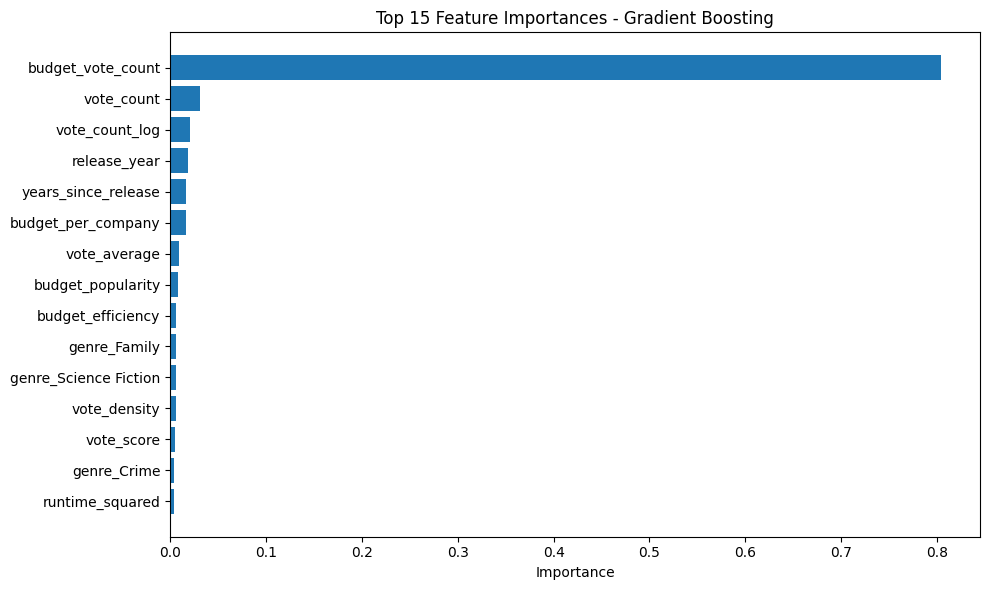

  CV R² Scores: ['0.7458', '0.7300', '0.7369', '0.7523', '0.7691']
  Mean CV R²: 0.7468 (±0.0269)


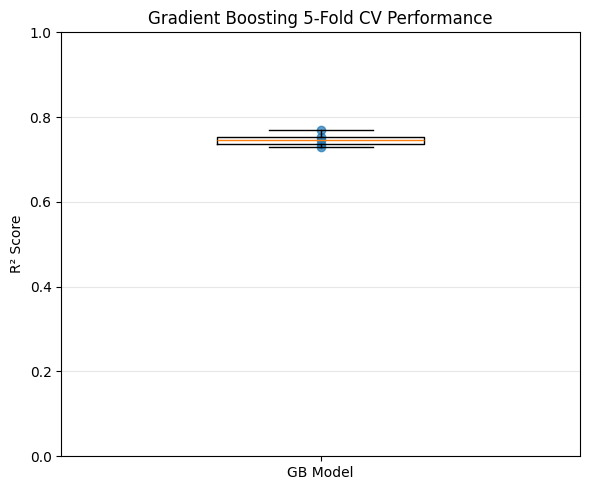

In [86]:
feature_importance_gb = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
for idx, row in feature_importance_gb.head(15).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:35s} {row['importance']:.4f}")

top_n = 15
top_features = feature_importance_gb.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()

# Cross-validation
cv_scores_gb = cross_val_score(
    gb_model, X_train_scaled, y_train_yeo, 
    cv=5, scoring='r2', n_jobs=-1
)
print(f"  CV R² Scores: {[f'{s:.4f}' for s in cv_scores_gb]}")
print(f"  Mean CV R²: {cv_scores_gb.mean():.4f} (±{cv_scores_gb.std() * 2:.4f})")

plt.figure(figsize=(6, 5))

# boxplot of CV scores
plt.boxplot(cv_scores_gb, vert=True, widths=0.4)
plt.scatter(
    np.ones_like(cv_scores_gb), cv_scores_gb,
    alpha=0.7
)

plt.ylabel('R² Score')
plt.title('Gradient Boosting 5-Fold CV Performance')
plt.xticks([1], ['GB Model'])
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Top 15 Most Important Features:
  36. budget_vote_count                   0.7258
  31. years_since_release                 0.0264
   4. release_year                        0.0195
  35. budget_popularity                   0.0188
  25. vote_count_log                      0.0185
  51. vote_count                          0.0179
  22. budget_per_company                  0.0172
  50. vote_average                        0.0170
  45. budget_efficiency                   0.0121
  26. vote_density                        0.0117
  46. marketing_indicator                 0.0092
  27. vote_score                          0.0083
   5. release_month                       0.0071
  44. complexity_score                    0.0068
  15. genre_Family                        0.0066


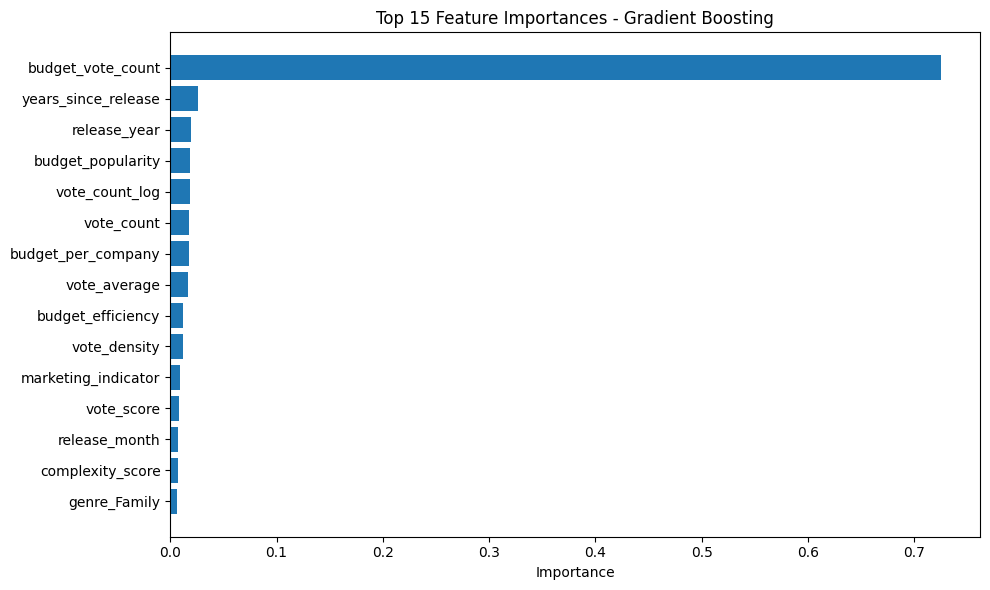

  CV R² Scores: ['0.7499', '0.7386', '0.7425', '0.7646', '0.7743']
  Mean CV R²: 0.7540 (±0.0270)


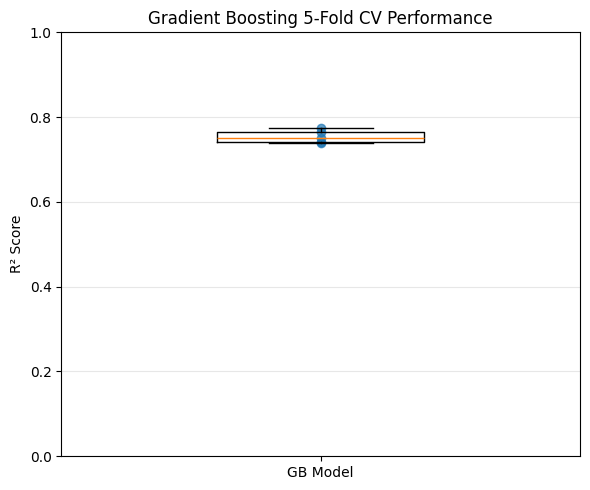

In [88]:
feature_importance_gb = pd.DataFrame({
    'feature': feature_names,
    'importance': tuned_gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
for idx, row in feature_importance_gb.head(15).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:35s} {row['importance']:.4f}")

top_n = 15
top_features = feature_importance_gb.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()

# Cross-validation
cv_scores_gb = cross_val_score(
    tuned_gb_model, X_train_scaled, y_train_yeo, 
    cv=5, scoring='r2', n_jobs=-1
)
print(f"  CV R² Scores: {[f'{s:.4f}' for s in cv_scores_gb]}")
print(f"  Mean CV R²: {cv_scores_gb.mean():.4f} (±{cv_scores_gb.std() * 2:.4f})")

plt.figure(figsize=(6, 5))

# boxplot of CV scores
plt.boxplot(cv_scores_gb, vert=True, widths=0.4)
plt.scatter(
    np.ones_like(cv_scores_gb), cv_scores_gb,
    alpha=0.7
)

plt.ylabel('R² Score')
plt.title('Gradient Boosting 5-Fold CV Performance')
plt.xticks([1], ['GB Model'])
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [118]:
def build_regression_model(meta, 
                           hidden_1=256, 
                           hidden_2=128, 
                           hidden_3=64,
                           hidden_4=32,
                           dropout_1=0.3,
                           dropout_2=0.3,
                           dropout_3=0.2,
                           learning_rate=0.001):
    n_features = meta["n_features_in_"]
    
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(n_features,)),
        
        # Hidden Layer 1
        keras.layers.Dense(hidden_1, activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_1),
        
        # Hidden Layer 2
        keras.layers.Dense(hidden_2, activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_2),
        
        # Hidden Layer 3
        keras.layers.Dense(hidden_3, activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_3),
        
        # Hidden Layer 4
        keras.layers.Dense(hidden_4, activation="relu"),
        keras.layers.Dropout(dropout_3),
        
        # Output layer (single neuron for regression)
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[
            keras.metrics.RootMeanSquaredError(name="rmse"),
            keras.metrics.MeanAbsoluteError(name="mae")
        ]
    )
    
    return model


# Early stopping: stop training if validation loss doesn't improve
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,  # stop if no improvement for 20 epochs
    restore_best_weights=True,  # restore weights from best epoch
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # reduce LR by half
    patience=10,  # wait 10 epochs before reducing
    min_lr=1e-7,  # minimum learning rate
    verbose=1
)


print("\n Building Neural Network Model...")

nn_model = KerasRegressor(
    model=build_regression_model,
    
    # Architecture hyperparameters
    hidden_1=256,
    hidden_2=128,
    hidden_3=64,
    hidden_4=32,
    dropout_1=0.3,
    dropout_2=0.3,
    dropout_3=0.2,
    learning_rate=0.001,
    
    # Training hyperparameters
    epochs=150,
    batch_size=32,  # process 32 samples at a time
    validation_split=0.2,  # use 20% of training data for validation
    callbacks=[earlystop, reduce_lr],
    verbose=1,  # show training progress
    random_state=RANDOM_STATE
)

print("Neural Network configured")
print(f"   Architecture: 256 → 128 → 64 → 32 → 1")
print(f"   Max Epochs: 150")
print(f"   Batch Size: 32")
print(f"   Validation Split: 20%")



# Train on Yeo-Johnson transformed data
nn_model.fit(X_train_scaled, y_train_yeo)

history = nn_model.history_

# Predictions in Yeo-Johnson space
y_train_pred_nn_yeo = nn_model.predict(X_train_scaled)
y_test_pred_nn_yeo = nn_model.predict(X_test_scaled)

# Convert back to original scale ($)
y_train_pred_nn = pt_yeo.inverse_transform(y_train_pred_nn_yeo.reshape(-1, 1)).flatten()
y_test_pred_nn = pt_yeo.inverse_transform(y_test_pred_nn_yeo.reshape(-1, 1)).flatten()


# Training set
train_rmse_nn_yeo = np.sqrt(mean_squared_error(y_train_yeo, y_train_pred_nn_yeo))
train_mae_nn_yeo = mean_absolute_error(y_train_yeo, y_train_pred_nn_yeo)
train_r2_nn_yeo = r2_score(y_train_yeo, y_train_pred_nn_yeo)

# Test set
test_rmse_nn_yeo = np.sqrt(mean_squared_error(y_test_yeo, y_test_pred_nn_yeo))
test_mae_nn_yeo = mean_absolute_error(y_test_yeo, y_test_pred_nn_yeo)
test_r2_nn_yeo = r2_score(y_test_yeo, y_test_pred_nn_yeo)

print(f"  Train RMSE: {train_rmse_nn_yeo:.4f} | Test RMSE: {test_rmse_nn_yeo:.4f}")
print(f"  Train MAE:  {train_mae_nn_yeo:.4f} | Test MAE:  {test_mae_nn_yeo:.4f}")
print(f"  Train R²:   {train_r2_nn_yeo:.4f} | Test R²:   {test_r2_nn_yeo:.4f}")

print("\nPerformance Metrics (Original Dollar Scale):")
print("-" * 60)

# Training set
train_rmse_nn_dollar = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
train_mae_nn_dollar = mean_absolute_error(y_train, y_train_pred_nn)
train_r2_nn_dollar = r2_score(y_train, y_train_pred_nn)

# Test set
test_rmse_nn_dollar = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))
test_mae_nn_dollar = mean_absolute_error(y_test, y_test_pred_nn)
test_r2_nn_dollar = r2_score(y_test, y_test_pred_nn)

print(f"  Train RMSE: ${train_rmse_nn_dollar:,.0f}")
print(f"  Test RMSE:  ${test_rmse_nn_dollar:,.0f}")
print(f"  Train MAE:  ${train_mae_nn_dollar:,.0f}")
print(f"  Test MAE:   ${test_mae_nn_dollar:,.0f}")
print(f"  Train R²:   {train_r2_nn_dollar:.4f}")
print(f"  Test R²:    {test_r2_nn_dollar:.4f}")


 Building Neural Network Model...
Neural Network configured
   Architecture: 256 → 128 → 64 → 32 → 1
   Max Epochs: 150
   Batch Size: 32
   Validation Split: 20%
Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 37592.7539 - mae: 184.1364 - rmse: 193.8876 - val_loss: 36757.7969 - val_mae: 181.6686 - val_rmse: 191.7223 - learning_rate: 0.0010
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32836.2227 - mae: 172.7771 - rmse: 181.2067 - val_loss: 28693.4160 - val_mae: 161.6150 - val_rmse: 169.3903 - learning_rate: 0.0010
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20870.8711 - mae: 135.5346 - rmse: 144.4663 - val_loss: 11914.3496 - val_mae: 97.9389 - val_rmse: 109.1512 - learning_rate: 0.0010
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9140.3555 - mae: 80.9134 - rmse: 95.6033 - val_loss: 4882.8779 - val_mae: 52.4811 - val_rmse: 69.8749 - learning_rate: 0.0010
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5079.4805 - mae: 56

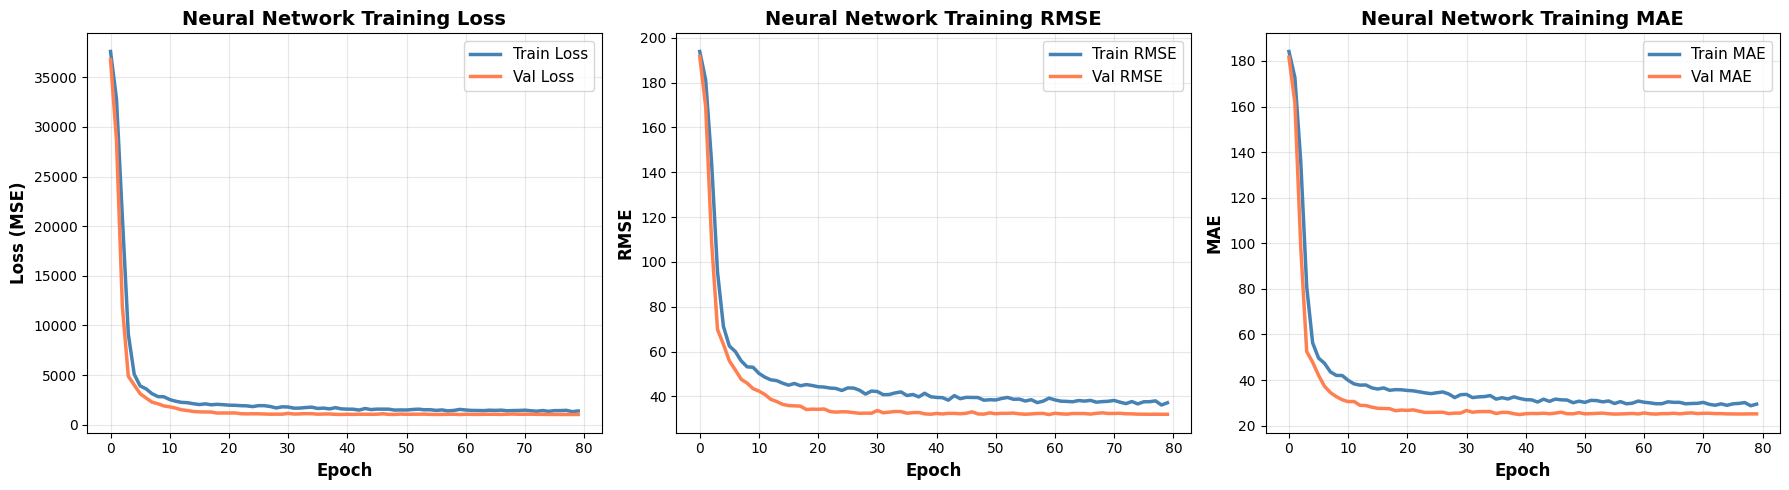

In [120]:
if history is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(history['loss'], label='Train Loss', linewidth=2.5, color='steelblue')
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2.5, color='coral')
    axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontweight='bold', fontsize=12)
    axes[0].set_title('Neural Network Training Loss', fontweight='bold', fontsize=14)
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)

    # RMSE
    axes[1].plot(history['rmse'], label='Train RMSE', linewidth=2.5, color='steelblue')
    axes[1].plot(history['val_rmse'], label='Val RMSE', linewidth=2.5, color='coral')
    axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('RMSE', fontweight='bold', fontsize=12)
    axes[1].set_title('Neural Network Training RMSE', fontweight='bold', fontsize=14)
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)

    # MAE
    axes[2].plot(history['mean_absolute_error'], label='Train MAE', linewidth=2.5, color='steelblue')
    axes[2].plot(history['val_mae'], label='Val MAE', linewidth=2.5, color='coral')
    axes[2].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[2].set_ylabel('MAE', fontweight='bold', fontsize=12)
    axes[2].set_title('Neural Network Training MAE', fontweight='bold', fontsize=14)
    axes[2].legend(fontsize=11)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [126]:
gb_baseline_df = pd.DataFrame(
    {
        "Model": ["GB Baseline"],
        
        # Yeo-Johnson space
        "Train RMSE (Yeo)": [train_rmse_gb_yeo],
        "Test RMSE (Yeo)":  [test_rmse_gb_yeo],
        "Train MAE (Yeo)":  [train_mae_gb_yeo],
        "Test MAE (Yeo)":   [test_mae_gb_yeo],
        "Train R² (Yeo)":   [train_r2_gb_yeo],
        "Test R² (Yeo)":    [test_r2_gb_yeo],
        
        # Original dollar scale
        "Train RMSE ($)":   [train_rmse_gb_dollar],
        "Test RMSE ($)":    [test_rmse_gb_dollar],
        "Train MAE ($)":    [train_mae_gb_dollar],
        "Test MAE ($)":     [test_mae_gb_dollar],
        "Train R² ($)":     [train_r2_gb_dollar],
        "Test R² ($)":      [test_r2_gb_dollar],
    }
)

print("\nGradient Boosting (Baseline) Performance")
print("\nYeo-Johnson Transformed Space:")
print(f"  Train RMSE (Yeo): {train_rmse_gb_yeo:.4f}")
print(f"  Test  RMSE (Yeo): {test_rmse_gb_yeo:.4f}")
print(f"  Train MAE  (Yeo): {train_mae_gb_yeo:.4f}")
print(f"  Test  MAE  (Yeo): {test_mae_gb_yeo:.4f}")
print(f"  Train R²   (Yeo): {train_r2_gb_yeo:.4f}")
print(f"  Test  R²   (Yeo): {test_r2_gb_yeo:.4f}")

print("\nOriginal Dollar Scale:")
print(f"  Train RMSE ($): {train_rmse_gb_dollar:,.0f}")
print(f"  Test  RMSE ($): {test_rmse_gb_dollar:,.0f}")
print(f"  Train MAE  ($): {train_mae_gb_dollar:,.0f}")
print(f"  Test  MAE  ($): {test_mae_gb_dollar:,.0f}")
print(f"  Train R²    : {train_r2_gb_dollar:.4f}")
print(f"  Test  R²    : {test_r2_gb_dollar:.4f}")


Gradient Boosting (Baseline) Performance

Yeo-Johnson Transformed Space:
  Train RMSE (Yeo): 26.2175
  Test  RMSE (Yeo): 32.2241
  Train MAE  (Yeo): 20.3676
  Test  MAE  (Yeo): 24.8360
  Train R²   (Yeo): 0.8239
  Test  R²   (Yeo): 0.7566

Original Dollar Scale:
  Train RMSE ($): 73,141,161
  Test  RMSE ($): 126,170,596
  Train MAE  ($): 40,244,451
  Test  MAE  ($): 54,661,126
  Train R²    : 0.8257
  Test  R²    : 0.6851


In [130]:
train_mae_tuned_yeo = mean_absolute_error(y_train_yeo, y_train_pred_tuned_yeo)
test_mae_tuned_yeo  = mean_absolute_error(y_test_yeo,  y_test_pred_tuned_yeo)

train_rmse_tuned_dollar = np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))
train_mae_tuned_dollar  = mean_absolute_error(y_train, y_train_pred_tuned)
train_r2_tuned_dollar   = r2_score(y_train, y_train_pred_tuned)

print("\nGradient Boosting (Tuned) Performance")

print("\nYeo-Johnson Transformed Space:")
print(f"  Train RMSE (Yeo): {train_rmse_tuned_yeo:.4f}")
print(f"  Test  RMSE (Yeo): {test_rmse_tuned_yeo:.4f}")
print(f"  Train MAE  (Yeo): {train_mae_tuned_yeo:.4f}")
print(f"  Test  MAE  (Yeo): {test_mae_tuned_yeo:.4f}")
print(f"  Train R²   (Yeo): {train_r2_tuned_yeo:.4f}")
print(f"  Test  R²   (Yeo): {test_r2_tuned_yeo:.4f}")

print("\nOriginal Dollar Scale:")
print(f"  Train RMSE ($): {train_rmse_tuned_dollar:,.0f}")
print(f"  Test  RMSE ($): {test_rmse_tuned_dollar:,.0f}")
print(f"  Train MAE  ($): {train_mae_tuned_dollar:,.0f}")
print(f"  Test  MAE  ($): {test_mae_tuned_dollar:,.0f}")
print(f"  Train R²    : {train_r2_tuned_dollar:.4f}")
print(f"  Test  R²    : {test_r2_tuned_dollar:.4f}")


Gradient Boosting (Tuned) Performance

Yeo-Johnson Transformed Space:
  Train RMSE (Yeo): 22.5507
  Test  RMSE (Yeo): 31.9507
  Train MAE  (Yeo): 17.5784
  Test  MAE  (Yeo): 24.6230
  Train R²   (Yeo): 0.8697
  Test  R²   (Yeo): 0.7607

Original Dollar Scale:
  Train RMSE ($): 62,860,199
  Test  RMSE ($): 122,879,682
  Train MAE  ($): 34,661,678
  Test  MAE  ($): 54,741,481
  Train R²    : 0.8712
  Test  R²    : 0.7013


In [134]:
print("\nNeural Network Performance")

print("\nYeo-Johnson Transformed Space:")
print(f"  Train RMSE (Yeo): {train_rmse_nn_yeo:.4f}")
print(f"  Test  RMSE (Yeo): {test_rmse_nn_yeo:.4f}")
print(f"  Train MAE  (Yeo): {train_mae_nn_yeo:.4f}")
print(f"  Test  MAE  (Yeo): {test_mae_nn_yeo:.4f}")
print(f"  Train R²   (Yeo): {train_r2_nn_yeo:.4f}")
print(f"  Test  R²   (Yeo): {test_r2_nn_yeo:.4f}")

print("\nOriginal Dollar Scale:")
print(f"  Train RMSE ($): {train_rmse_nn_dollar:,.0f}")
print(f"  Test  RMSE ($): {test_rmse_nn_dollar:,.0f}")
print(f"  Train MAE  ($): {train_mae_nn_dollar:,.0f}")
print(f"  Test MAE  ($): {test_mae_nn_dollar:,.0f}")
print(f"  Train R²    : {train_r2_nn_dollar:.4f}")
print(f"  Test  R²    : {test_r2_nn_dollar:.4f}")



Neural Network Performance

Yeo-Johnson Transformed Space:
  Train RMSE (Yeo): 27.0409
  Test  RMSE (Yeo): 34.9116
  Train MAE  (Yeo): 20.8503
  Test  MAE  (Yeo): 26.9389
  Train R²   (Yeo): 0.8127
  Test  R²   (Yeo): 0.7143

Original Dollar Scale:
  Train RMSE ($): 106,059,447
  Test  RMSE ($): 131,136,627
  Train MAE  ($): 45,456,656
  Test MAE  ($): 59,311,784
  Train R²    : 0.6335
  Test  R²    : 0.6598


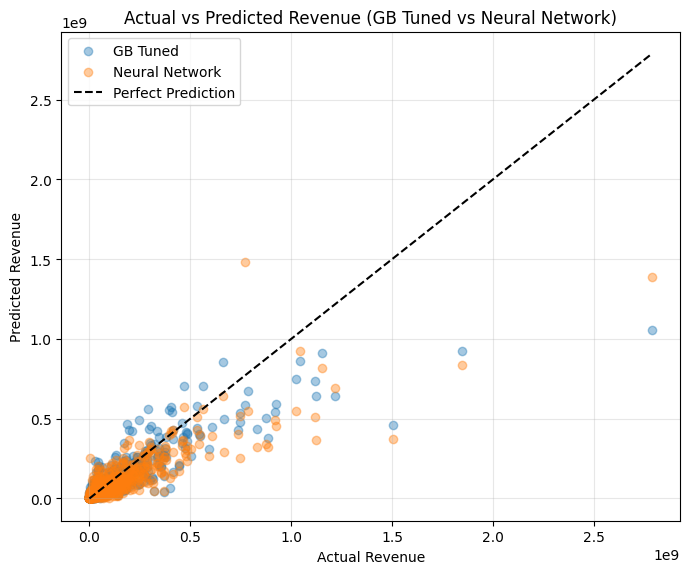

In [140]:
plt.figure(figsize=(7, 6))
# Scatter for Tuned GB
plt.scatter(
    y_test, y_test_pred_tuned,
    alpha=0.4,
    label='GB Tuned',
)
# Scatter for Neural Network
plt.scatter(
    y_test, y_test_pred_nn,
    alpha=0.4,
    label='Neural Network',
)
# Ideal prediction line
max_val = max(y_test.max(), y_test_pred_tuned.max(), y_test_pred_nn.max())
plt.plot([0, max_val], [0, max_val], 'k--', label='Perfect Prediction')

plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue (GB Tuned vs Neural Network)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Initializing TreeExplainer for Gradient Boosting...
Calculating SHAP values for 500 samples...

SHAP Summary Plot:


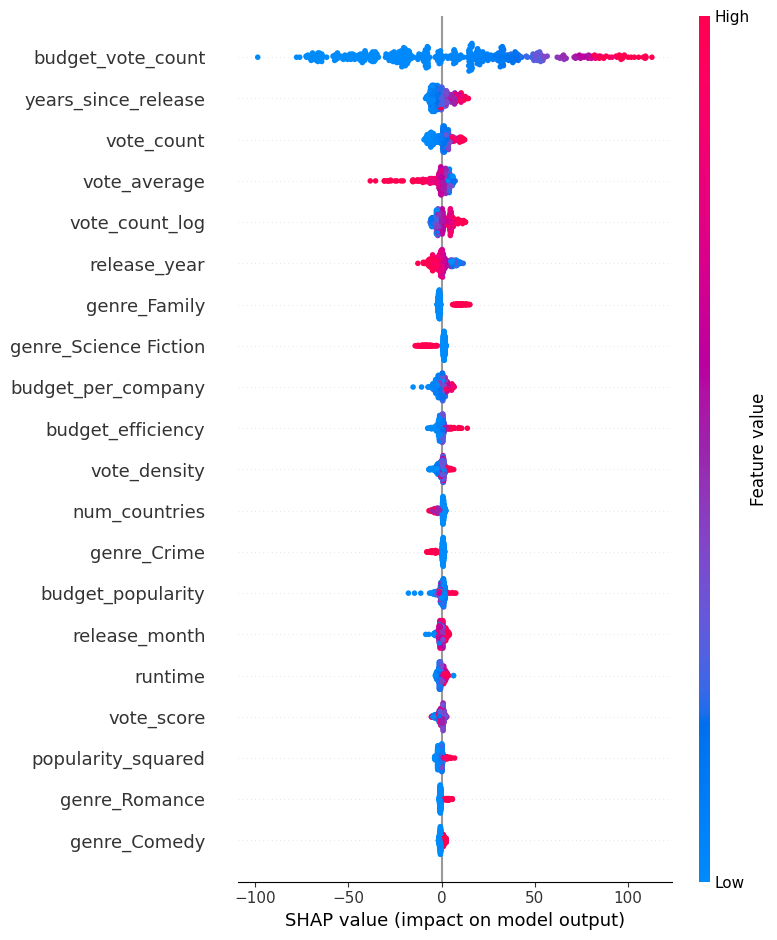


Top 20 features by mean |SHAP|:
              feature  importance
    budget_vote_count   36.666578
  years_since_release    4.001777
           vote_count    3.818336
         vote_average    3.781563
       vote_count_log    3.270500
         release_year    3.111144
         genre_Family    2.515756
genre_Science Fiction    2.453259
   budget_per_company    2.002417
    budget_efficiency    1.466425
         vote_density    1.456593
        num_countries    1.435822
          genre_Crime    1.422125
    budget_popularity    1.295817
        release_month    1.183132
              runtime    1.173522
           vote_score    1.161159
   popularity_squared    1.119840
        genre_Romance    1.005161
         genre_Comedy    0.969245


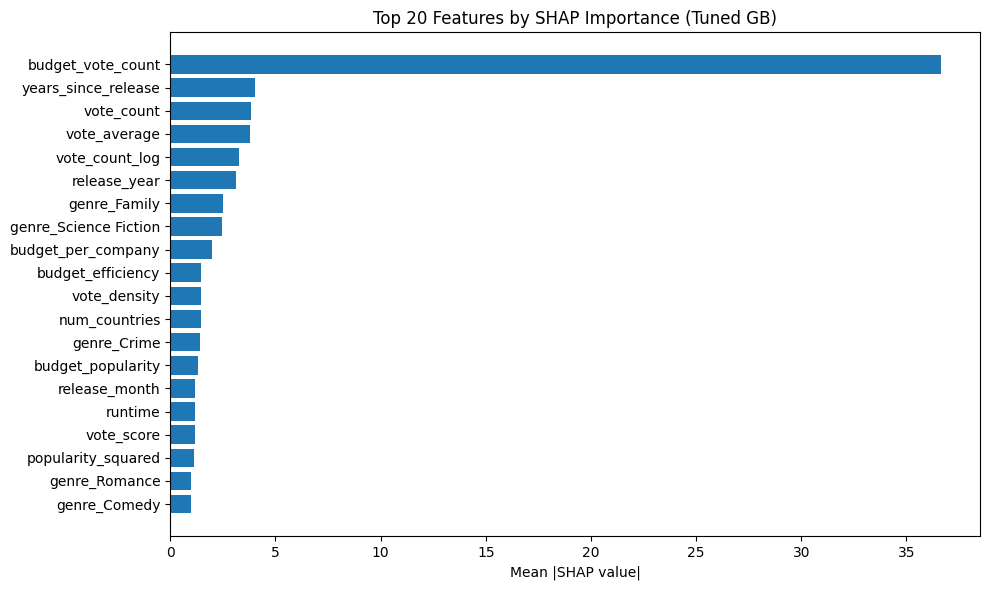


SHAP dependence plot for top feature: budget_vote_count


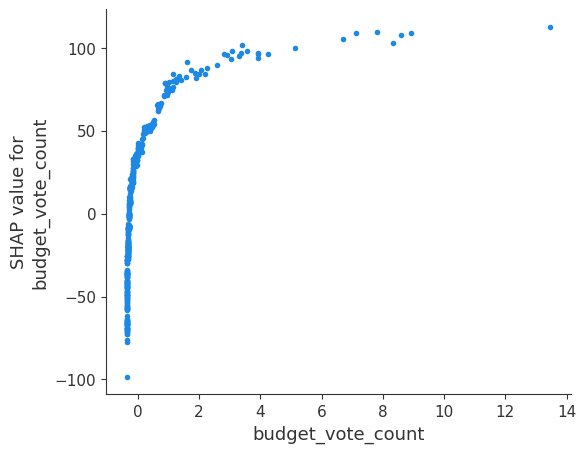

In [144]:
import shap

gb_explain_model = tuned_gb_model 

# Sample a subset of test data for speed
sample_size = min(500, X_test_scaled.shape[0])
X_test_sample = X_test_scaled[:sample_size]
X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

print("Initializing TreeExplainer for Gradient Boosting...")
explainer_gb = shap.TreeExplainer(gb_explain_model)

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values_gb = explainer_gb.shap_values(X_test_sample)

print("\nSHAP Summary Plot:")
shap.summary_plot(
    shap_values_gb,
    X_test_sample_df,
    max_display=20,
    show=True
)

print("\nTop 20 features by mean |SHAP|:")
gb_importance = (
    np.abs(shap_values_gb).mean(axis=0)
)

shap_importance_gb = (
    pd.DataFrame({"feature": feature_names, "importance": gb_importance})
    .sort_values("importance", ascending=False)
)

print(shap_importance_gb.head(20).to_string(index=False))

plt.figure(figsize=(10, 6))
top_20 = shap_importance_gb.head(20)
plt.barh(top_20["feature"][::-1], top_20["importance"][::-1])
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Features by SHAP Importance (Tuned GB)")
plt.tight_layout()
plt.show()

top_feature = shap_importance_gb.iloc[0]["feature"]
print(f"\nSHAP dependence plot for top feature: {top_feature}")

shap.dependence_plot(
    top_feature,
    shap_values_gb,
    X_test_sample_df,
    interaction_index=None,
    show=True
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Computing SHAP values for 150 samples...


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  1%|          | 1/150 [00:05<13:34,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  1%|▏         | 2/150 [00:10<12:40,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  2%|▏         | 3/150 [00:15<12:41,  5.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  3%|▎         | 4/150 [00:20<12:47,  5.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  3%|▎         | 5/150 [00:26<12:49,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  4%|▍         | 6/150 [00:31<12:27,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  5%|▍         | 7/150 [00:35<11:51,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 961us/step


  5%|▌         | 8/150 [00:40<11:14,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 979us/step


  6%|▌         | 9/150 [00:44<10:50,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  7%|▋         | 10/150 [00:49<11:12,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step


  7%|▋         | 11/150 [00:53<10:43,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  8%|▊         | 12/150 [00:58<10:52,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


  9%|▊         | 13/150 [01:04<11:12,  4.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step


  9%|▉         | 14/150 [01:08<10:36,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 10%|█         | 15/150 [01:12<10:21,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 11%|█         | 16/150 [01:17<10:18,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 11%|█▏        | 17/150 [01:22<10:30,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 986us/step


 12%|█▏        | 18/150 [01:26<10:10,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 13%|█▎        | 19/150 [01:31<10:18,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 13%|█▎        | 20/150 [01:36<10:19,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 14%|█▍        | 21/150 [01:41<10:02,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 15%|█▍        | 22/150 [01:45<09:57,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 15%|█▌        | 23/150 [01:50<09:58,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 16%|█▌        | 24/150 [01:55<09:53,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 17%|█▋        | 25/150 [01:59<09:45,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 17%|█▋        | 26/150 [02:04<09:39,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 18%|█▊        | 27/150 [02:10<10:05,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 19%|█▊        | 28/150 [02:14<09:54,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 19%|█▉        | 29/150 [02:20<10:30,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 20%|██        | 30/150 [02:25<10:24,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 21%|██        | 31/150 [02:30<09:56,  5.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 949us/step


 21%|██▏       | 32/150 [02:34<09:23,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 22%|██▏       | 33/150 [02:39<09:30,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step


 23%|██▎       | 34/150 [02:44<09:03,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 23%|██▎       | 35/150 [02:48<08:49,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step


 24%|██▍       | 36/150 [02:52<08:29,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 25%|██▍       | 37/150 [02:57<08:53,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 25%|██▌       | 38/150 [03:02<08:45,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step


 26%|██▌       | 39/150 [03:06<08:30,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 27%|██▋       | 40/150 [03:11<08:36,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 27%|██▋       | 41/150 [03:16<08:33,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 28%|██▊       | 42/150 [03:21<08:31,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 29%|██▊       | 43/150 [03:26<08:27,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 29%|██▉       | 44/150 [03:31<08:33,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step


 30%|███       | 45/150 [03:35<08:10,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 31%|███       | 46/150 [03:40<08:06,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 31%|███▏      | 47/150 [03:45<08:10,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 32%|███▏      | 48/150 [03:49<07:58,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 33%|███▎      | 49/150 [03:54<07:56,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 33%|███▎      | 50/150 [03:59<07:51,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 34%|███▍      | 51/150 [04:03<07:48,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 35%|███▍      | 52/150 [04:08<07:43,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 35%|███▌      | 53/150 [04:13<07:33,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 36%|███▌      | 54/150 [04:18<07:34,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 37%|███▋      | 55/150 [04:22<07:28,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 37%|███▋      | 56/150 [04:27<07:31,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 38%|███▊      | 57/150 [04:33<07:43,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 39%|███▊      | 58/150 [04:37<07:31,  4.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 39%|███▉      | 59/150 [04:42<07:15,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 40%|████      | 60/150 [04:47<07:07,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 41%|████      | 61/150 [04:51<07:02,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 41%|████▏     | 62/150 [04:57<07:11,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step


 42%|████▏     | 63/150 [05:01<06:43,  4.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 43%|████▎     | 64/150 [05:06<06:51,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 43%|████▎     | 65/150 [05:12<07:19,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 44%|████▍     | 66/150 [05:16<06:55,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 45%|████▍     | 67/150 [05:22<07:00,  5.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 45%|████▌     | 68/150 [05:26<06:50,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 46%|████▌     | 69/150 [05:32<06:57,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 47%|████▋     | 70/150 [05:37<06:59,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 47%|████▋     | 71/150 [05:42<06:36,  5.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step  


 48%|████▊     | 72/150 [05:46<06:17,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 49%|████▊     | 73/150 [05:52<06:22,  4.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 49%|████▉     | 74/150 [05:56<06:11,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 50%|█████     | 75/150 [06:01<06:06,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 51%|█████     | 76/150 [06:06<06:00,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 51%|█████▏    | 77/150 [06:11<05:56,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 52%|█████▏    | 78/150 [06:16<05:50,  4.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 53%|█████▎    | 79/150 [06:21<05:43,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 53%|█████▎    | 80/150 [06:26<05:42,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 54%|█████▍    | 81/150 [06:30<05:29,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 55%|█████▍    | 82/150 [06:35<05:26,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 55%|█████▌    | 83/150 [06:40<05:22,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 56%|█████▌    | 84/150 [06:44<05:11,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 57%|█████▋    | 85/150 [06:49<05:07,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 57%|█████▋    | 86/150 [06:54<05:01,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 58%|█████▊    | 87/150 [06:59<05:07,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 59%|█████▊    | 88/150 [07:04<04:57,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 59%|█████▉    | 89/150 [07:08<04:52,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 60%|██████    | 90/150 [07:14<04:55,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 61%|██████    | 91/150 [07:19<04:51,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 61%|██████▏   | 92/150 [07:24<04:48,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 62%|██████▏   | 93/150 [07:29<04:53,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 63%|██████▎   | 94/150 [07:34<04:40,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 63%|██████▎   | 95/150 [07:39<04:30,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 64%|██████▍   | 96/150 [07:43<04:22,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 65%|██████▍   | 97/150 [07:48<04:14,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 65%|██████▌   | 98/150 [07:52<04:05,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 66%|██████▌   | 99/150 [07:58<04:05,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 67%|██████▋   | 100/150 [08:03<04:07,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 968us/step


 67%|██████▋   | 101/150 [08:07<03:53,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 68%|██████▊   | 102/150 [08:12<03:52,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 69%|██████▊   | 103/150 [08:17<03:51,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 69%|██████▉   | 104/150 [08:22<03:41,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 70%|███████   | 105/150 [08:26<03:34,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 71%|███████   | 106/150 [08:32<03:40,  5.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 71%|███████▏  | 107/150 [08:37<03:30,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 72%|███████▏  | 108/150 [08:42<03:25,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 73%|███████▎  | 109/150 [08:47<03:22,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 73%|███████▎  | 110/150 [08:52<03:20,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 74%|███████▍  | 111/150 [08:56<03:09,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 75%|███████▍  | 112/150 [09:01<03:01,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 75%|███████▌  | 113/150 [09:06<03:02,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 76%|███████▌  | 114/150 [09:11<02:52,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 77%|███████▋  | 115/150 [09:16<02:48,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 77%|███████▋  | 116/150 [09:21<02:47,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 78%|███████▊  | 117/150 [09:26<02:42,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 79%|███████▊  | 118/150 [09:30<02:36,  4.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 79%|███████▉  | 119/150 [09:36<02:34,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 80%|████████  | 120/150 [09:40<02:28,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 81%|████████  | 121/150 [09:45<02:23,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 81%|████████▏ | 122/150 [09:50<02:16,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 82%|████████▏ | 123/150 [09:55<02:12,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 83%|████████▎ | 124/150 [10:00<02:08,  4.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   


 83%|████████▎ | 125/150 [10:05<01:59,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 84%|████████▍ | 126/150 [10:10<01:57,  4.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 85%|████████▍ | 127/150 [10:15<01:52,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 85%|████████▌ | 128/150 [10:19<01:44,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 86%|████████▌ | 129/150 [10:24<01:40,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 87%|████████▋ | 130/150 [10:29<01:35,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 964us/step


 87%|████████▋ | 131/150 [10:33<01:28,  4.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 88%|████████▊ | 132/150 [10:38<01:23,  4.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 89%|████████▊ | 133/150 [10:43<01:21,  4.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 89%|████████▉ | 134/150 [10:47<01:15,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step  


 90%|█████████ | 135/150 [10:52<01:09,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 91%|█████████ | 136/150 [10:57<01:06,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 91%|█████████▏| 137/150 [11:02<01:01,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 92%|█████████▏| 138/150 [11:07<00:59,  5.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 93%|█████████▎| 139/150 [11:13<00:56,  5.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 93%|█████████▎| 140/150 [11:19<00:53,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 94%|█████████▍| 141/150 [11:24<00:49,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


 95%|█████████▍| 142/150 [11:31<00:47,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 95%|█████████▌| 143/150 [11:38<00:42,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 96%|█████████▌| 144/150 [11:44<00:37,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 97%|█████████▋| 145/150 [11:49<00:29,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 97%|█████████▋| 146/150 [11:55<00:22,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 98%|█████████▊| 147/150 [12:00<00:16,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 99%|█████████▊| 148/150 [12:05<00:11,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 99%|█████████▉| 149/150 [12:11<00:05,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


100%|██████████| 150/150 [12:17<00:00,  4.91s/it]


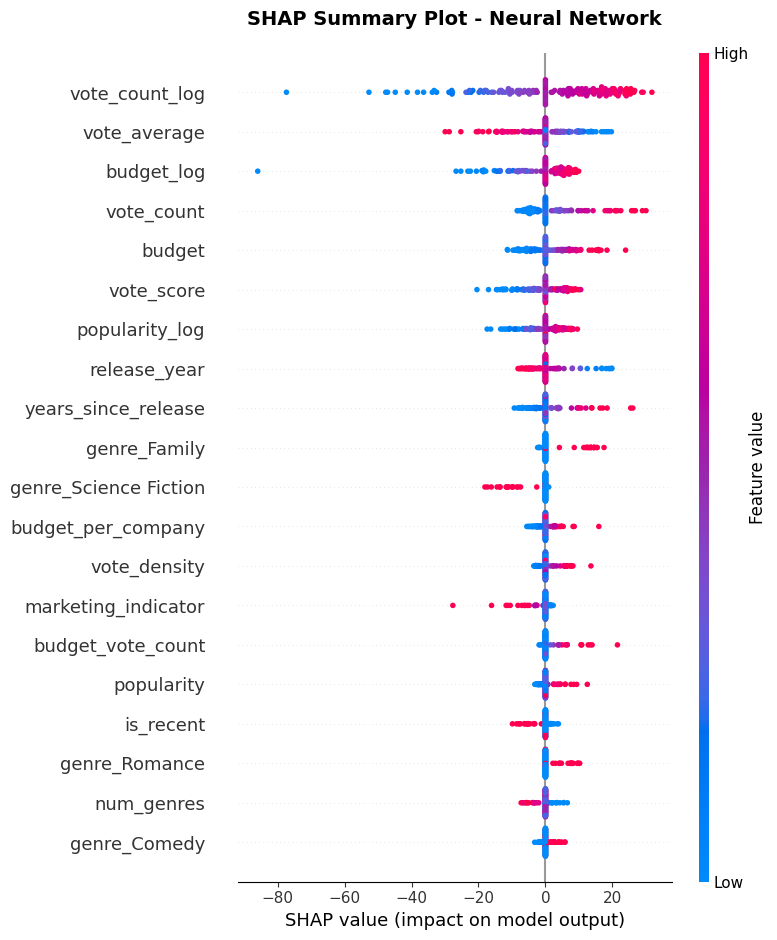

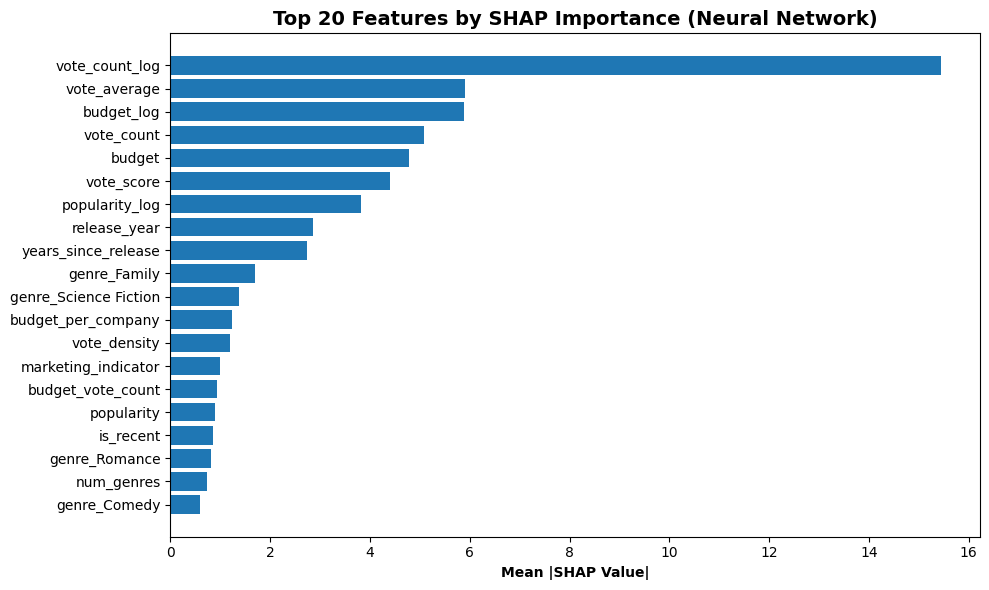


Top 10 NN SHAP Features:
            feature  importance
     vote_count_log   15.452874
       vote_average    5.897902
         budget_log    5.885345
         vote_count    5.077007
             budget    4.775424
         vote_score    4.404045
     popularity_log    3.819361
       release_year    2.860571
years_since_release    2.729594
       genre_Family    1.705491

Generating dependence plot for top NN feature: vote_count_log


<Figure size 800x500 with 0 Axes>

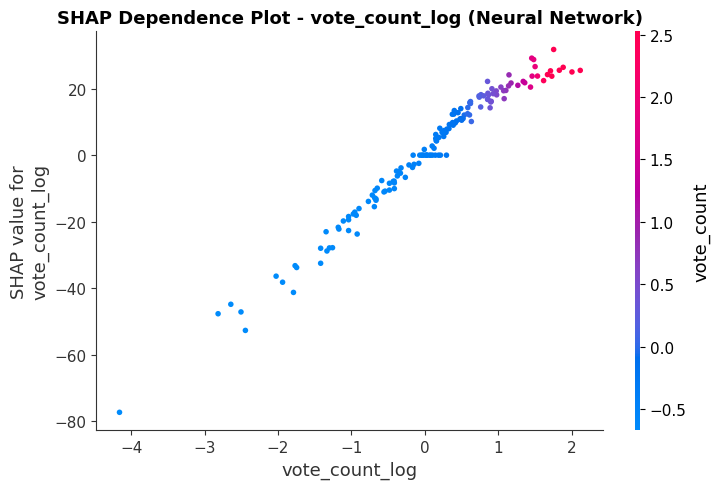

In [152]:
def nn_predict(X):
    X = np.array(X)
    preds = nn_model.predict(X)
    # return as 1D array for regression
    return preds.reshape(-1)

background_size = 50
background = shap.kmeans(X_train_scaled, background_size)

explainer_nn = shap.KernelExplainer(nn_predict, background)

sample_size = min(150, X_test_scaled.shape[0])
X_test_sample = shap.sample(X_test_scaled, sample_size)
X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

print(f"Computing SHAP values for {sample_size} samples...")
shap_values_nn = explainer_nn.shap_values(X_test_sample)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_nn,
    X_test_sample_df,
    max_display=20,
    show=False
)
plt.title("SHAP Summary Plot - Neural Network", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

importance_nn = np.abs(shap_values_nn).mean(axis=0)
shap_importance_nn = (
    pd.DataFrame({"feature": feature_names, "importance": importance_nn})
    .sort_values("importance", ascending=False)
)

top_20_nn = shap_importance_nn.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_nn["feature"][::-1], top_20_nn["importance"][::-1])
plt.xlabel("Mean |SHAP Value|", fontweight="bold")
plt.title("Top 20 Features by SHAP Importance (Neural Network)",
          fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nTop 10 NN SHAP Features:")
print(top_20_nn.head(10).to_string(index=False))

top_feature_nn = shap_importance_nn.iloc[0]["feature"]
print(f"\nGenerating dependence plot for top NN feature: {top_feature_nn}")

plt.figure(figsize=(8, 5))
shap.dependence_plot(
    top_feature_nn,
    shap_values_nn,
    X_test_sample_df,
    show=False
)
plt.title(f"SHAP Dependence Plot - {top_feature_nn} (Neural Network)",
          fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()


In [154]:
# ensemble model (stacking)
from sklearn.linear_model import Ridge

meta_features_train = np.column_stack([
    y_train_pred_gb_yeo,
    y_train_pred_nn_yeo
])

meta_features_test = np.column_stack([
    y_test_pred_gb_yeo,
    y_test_pred_nn_yeo
])

meta_learner = Ridge(alpha=1.0)
meta_learner.fit(meta_features_train, y_train_yeo)

print(f"\nMeta-learner coefficients:")
print(f"  Gradient Boosting: {meta_learner.coef_[0]:.4f}")
print(f"  Neural Network:    {meta_learner.coef_[1]:.4f}")
print(f"  Intercept:         {meta_learner.intercept_:.4f}")

y_train_pred_stack_yeo = meta_learner.predict(meta_features_train)
y_test_pred_stack_yeo = meta_learner.predict(meta_features_test)

y_train_pred_stack = pt_yeo.inverse_transform(y_train_pred_stack_yeo.reshape(-1, 1)).flatten()
y_test_pred_stack = pt_yeo.inverse_transform(y_test_pred_stack_yeo.reshape(-1, 1)).flatten()

train_rmse_stack_yeo = np.sqrt(mean_squared_error(y_train_yeo, y_train_pred_stack_yeo))
test_rmse_stack_yeo = np.sqrt(mean_squared_error(y_test_yeo, y_test_pred_stack_yeo))
train_r2_stack_yeo = r2_score(y_train_yeo, y_train_pred_stack_yeo)
test_r2_stack_yeo = r2_score(y_test_yeo, y_test_pred_stack_yeo)

test_rmse_stack_dollar = np.sqrt(mean_squared_error(y_test, y_test_pred_stack))
test_mae_stack_dollar = mean_absolute_error(y_test, y_test_pred_stack)
test_r2_stack_dollar = r2_score(y_test, y_test_pred_stack)

print("\nStacking Ensemble Results:")
print(f"  Train RMSE (Yeo): {train_rmse_stack_yeo:.4f}")
print(f"  Test RMSE (Yeo):  {test_rmse_stack_yeo:.4f}")
print(f"  Train R²:         {train_r2_stack_yeo:.4f}")
print(f"  Test R²:          {test_r2_stack_yeo:.4f}")
print(f"  Test RMSE ($):    ${test_rmse_stack_dollar:,.0f}")
print(f"  Test MAE ($):     ${test_mae_stack_dollar:,.0f}")
print(f"  Test R² ($):      {test_r2_stack_dollar:.4f}")


Meta-learner coefficients:
  Gradient Boosting: 0.5738
  Neural Network:    0.4972
  Intercept:         -10.5472

Stacking Ensemble Results:
  Train RMSE (Yeo): 25.0328
  Test RMSE (Yeo):  32.3043
  Train R²:         0.8395
  Test R²:          0.7554
  Test RMSE ($):    $113,037,453
  Test MAE ($):     $53,105,451
  Test R² ($):      0.7472


In [158]:
metrics_data = {
    'Model': [
        'Gradient Boosting (Baseline)',
        'Gradient Boosting (Tuned)',
        'Neural Network',
        'Stacking Ensemble'
    ],
    'Train R²': [
        train_r2_gb_yeo,
        train_r2_tuned_yeo,
        train_r2_nn_yeo,
        train_r2_stack_yeo
    ],
    'Test R²': [
        test_r2_gb_yeo,
        test_r2_tuned_yeo,
        test_r2_nn_yeo,
        test_r2_stack_yeo
    ],
    'Train RMSE (Yeo)': [
        train_rmse_gb_yeo,
        train_rmse_tuned_yeo,
        train_rmse_nn_yeo,
        train_rmse_stack_yeo
    ],
    'Test RMSE (Yeo)': [
        test_rmse_gb_yeo,
        test_rmse_tuned_yeo,
        test_rmse_nn_yeo,
        test_rmse_stack_yeo
    ],
    'Test RMSE ($)': [
        test_rmse_gb_dollar,
        test_rmse_tuned_dollar,
        test_rmse_nn_dollar,
        test_rmse_stack_dollar
    ],
    'Test MAE ($)': [
        test_mae_gb_dollar,
        test_mae_tuned_dollar,
        test_mae_nn_dollar,
        test_mae_stack_dollar
    ],
    'Test R² ($)': [
        test_r2_gb_dollar,
        test_r2_tuned_dollar,
        test_r2_nn_dollar,
        test_r2_stack_dollar
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# Calculate overfitting metric (difference between train and test R²)
df_metrics['Overfitting Gap'] = df_metrics['Train R²'] - df_metrics['Test R²']

print("\nComprehensive Model Performance Metrics")
print(df_metrics.to_string(index=False))




Comprehensive Model Performance Metrics
                       Model  Train R²  Test R²  Train RMSE (Yeo)  Test RMSE (Yeo)  Test RMSE ($)  Test MAE ($)  Test R² ($)  Overfitting Gap
Gradient Boosting (Baseline)  0.823932 0.756631         26.217519        32.224064   1.261706e+08  5.466113e+07     0.685054         0.067301
   Gradient Boosting (Tuned)  0.869739 0.760742         22.550652        31.950733   1.228797e+08  5.474148e+07     0.701269         0.108996
              Neural Network  0.812700 0.714344         27.040851        34.911589   1.311366e+08  5.931178e+07     0.659774         0.098356
           Stacking Ensemble  0.839485 0.755418         25.032786        32.304313   1.130375e+08  5.310545e+07     0.747207         0.084067


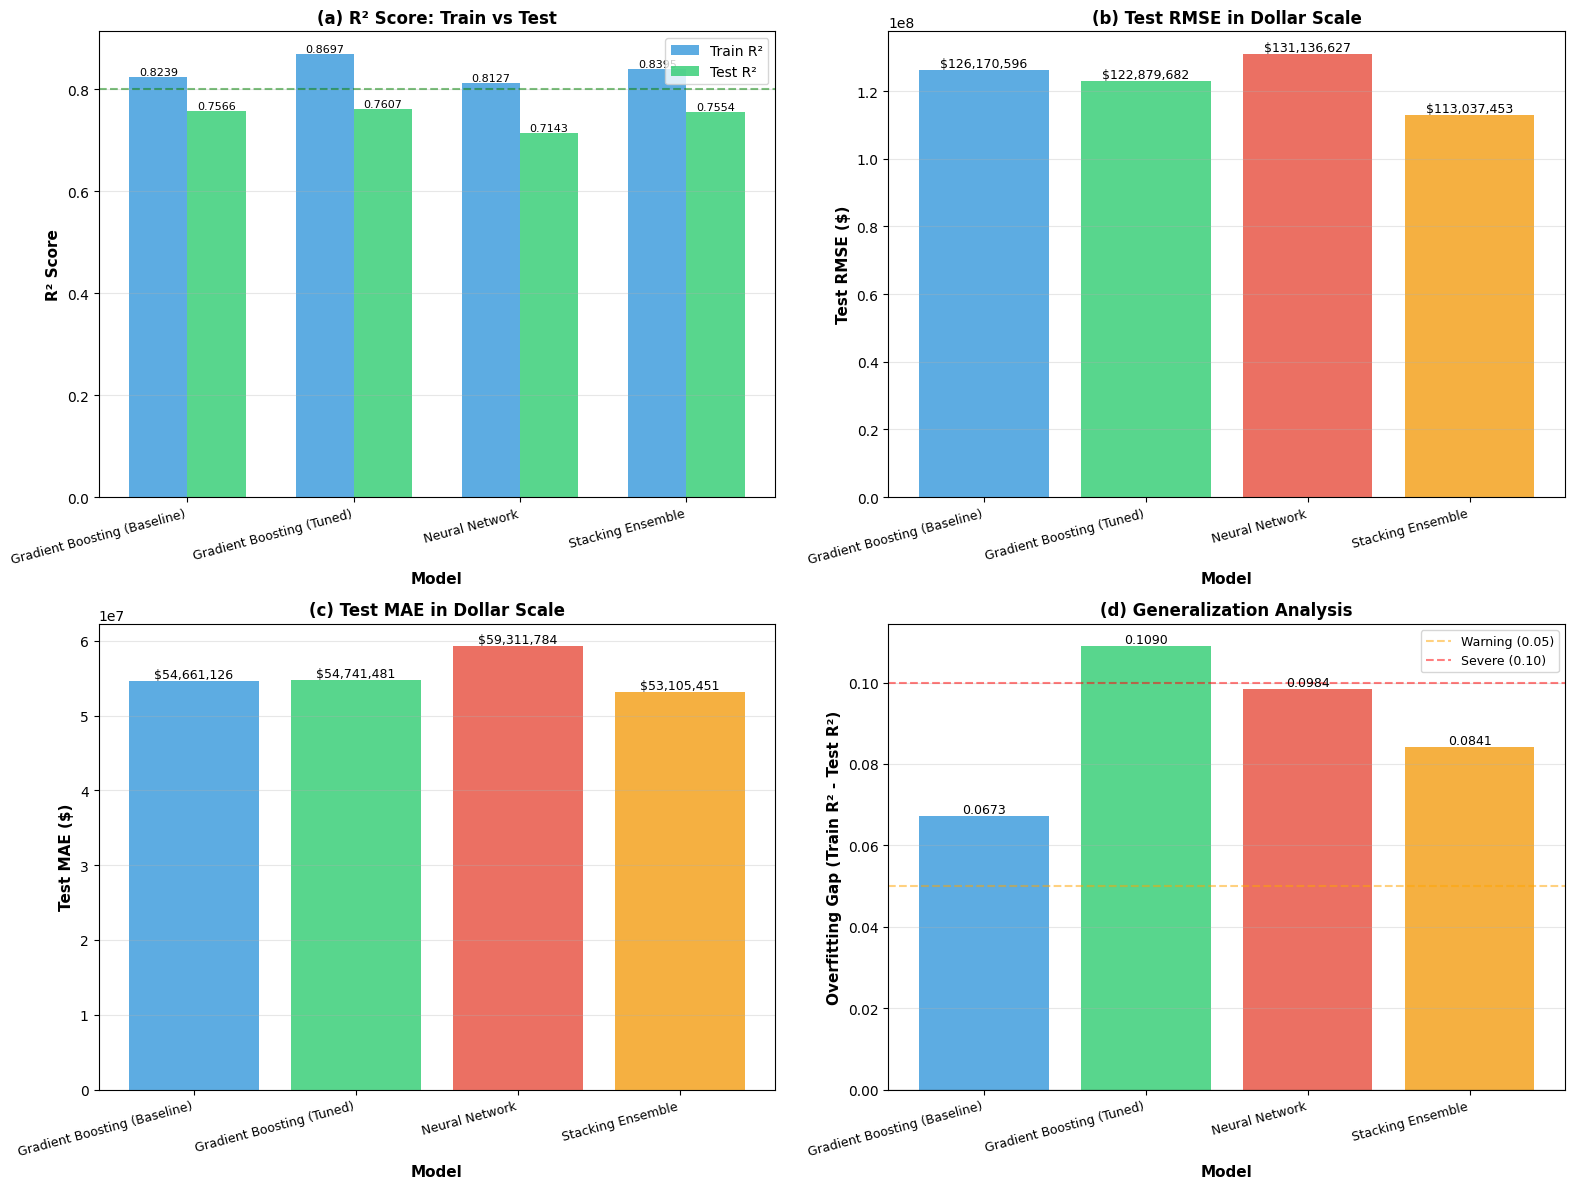

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = df_metrics['Model'].values
x_pos = np.arange(len(models))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

# Subplot 1: R² Score Comparison
ax1 = axes[0, 0]
bar_width = 0.35
train_bars = ax1.bar(x_pos - bar_width/2, df_metrics['Train R²'], 
                     bar_width, label='Train R²', alpha=0.8, color=colors[0])
test_bars = ax1.bar(x_pos + bar_width/2, df_metrics['Test R²'], 
                    bar_width, label='Test R²', alpha=0.8, color=colors[1])

ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('(a) R² Score: Train vs Test', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15, ha='right', fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (0.80)')

for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# Subplot 2: RMSE Comparison (Dollar Scale)
ax2 = axes[0, 1]
bars = ax2.bar(x_pos, df_metrics['Test RMSE ($)'], color=colors, alpha=0.8)
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('Test RMSE ($)', fontsize=11, fontweight='bold')
ax2.set_title('(b) Test RMSE in Dollar Scale', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=15, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

# Subplot 3: MAE Comparison (Dollar Scale)
ax3 = axes[1, 0]
bars = ax3.bar(x_pos, df_metrics['Test MAE ($)'], color=colors, alpha=0.8)
ax3.set_xlabel('Model', fontsize=11, fontweight='bold')
ax3.set_ylabel('Test MAE ($)', fontsize=11, fontweight='bold')
ax3.set_title('(c) Test MAE in Dollar Scale', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models, rotation=15, ha='right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

# Subplot 4: Overfitting Analysis
ax4 = axes[1, 1]
bars = ax4.bar(x_pos, df_metrics['Overfitting Gap'], color=colors, alpha=0.8)
ax4.set_xlabel('Model', fontsize=11, fontweight='bold')
ax4.set_ylabel('Overfitting Gap (Train R² - Test R²)', fontsize=11, fontweight='bold')
ax4.set_title('(d) Generalization Analysis', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models, rotation=15, ha='right', fontsize=9)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax4.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Warning (0.05)')
ax4.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Severe (0.10)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=9)

plt.tight_layout()
plt.show()

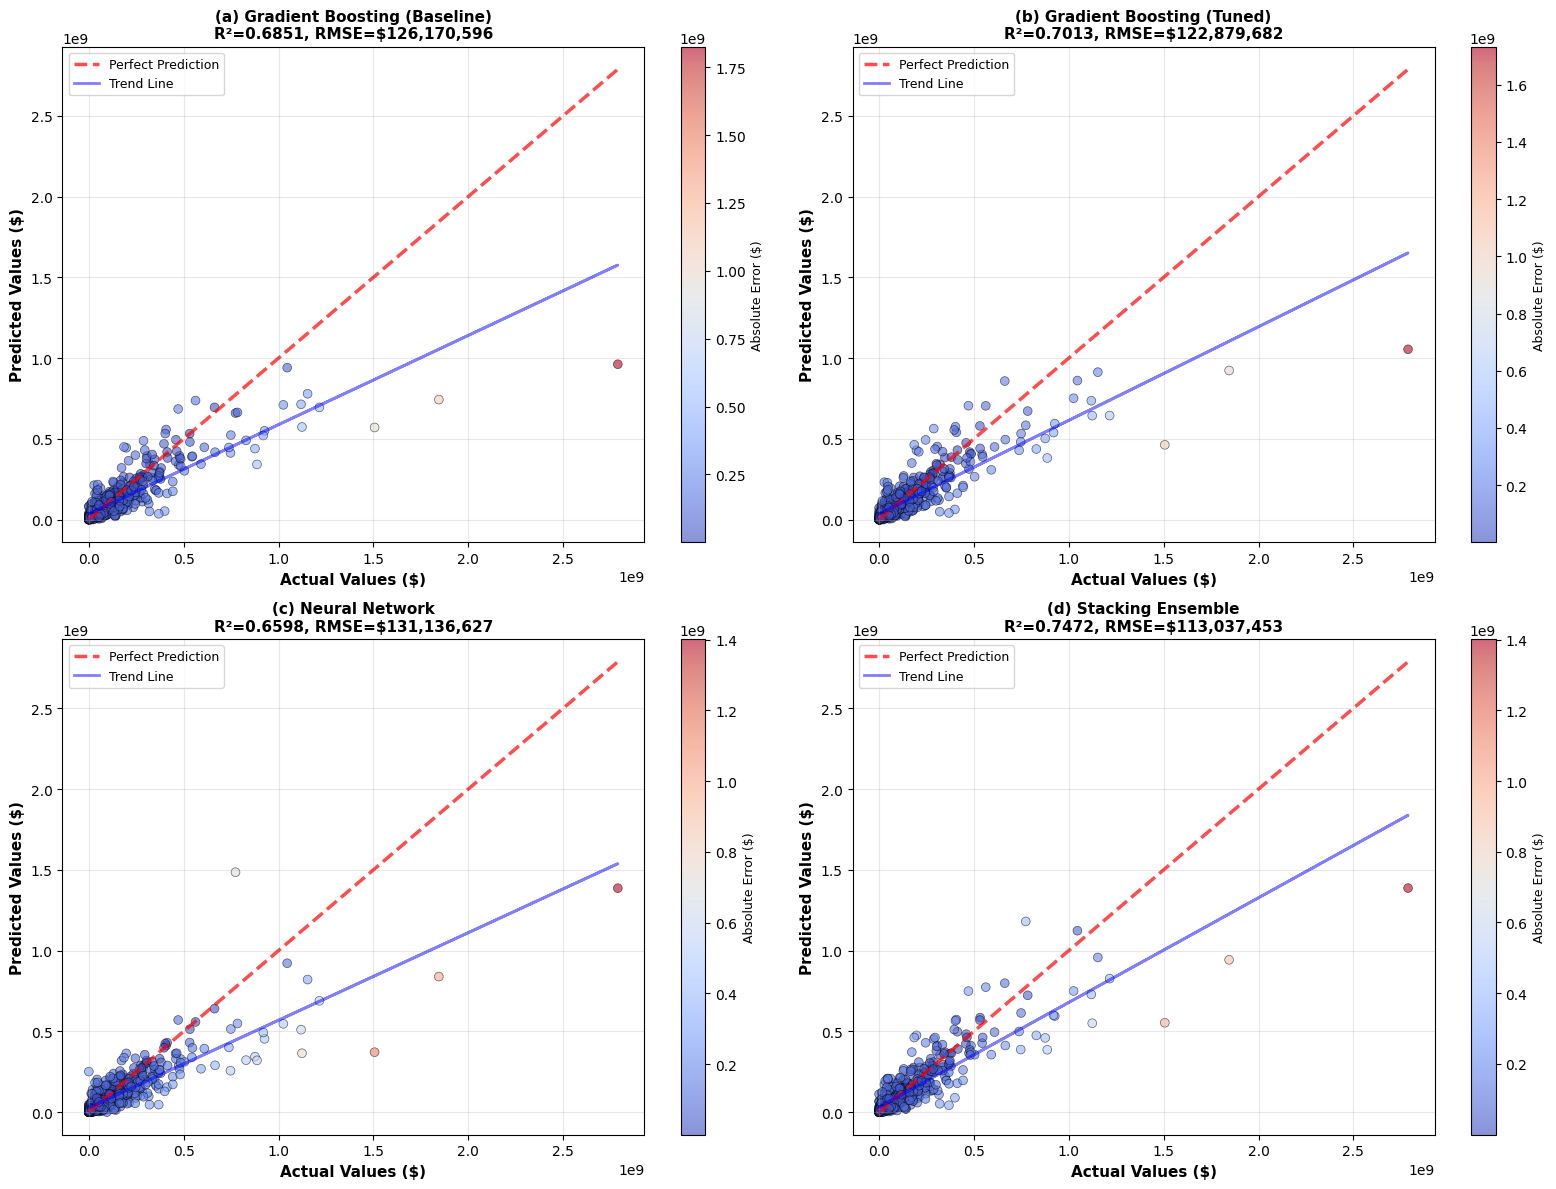

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

predictions_list = [
    ('Gradient Boosting (Baseline)', y_test_pred_gb, test_r2_gb_dollar, test_rmse_gb_dollar),
    ('Gradient Boosting (Tuned)', y_test_pred_tuned, test_r2_tuned_dollar, test_rmse_tuned_dollar),
    ('Neural Network', y_test_pred_nn, test_r2_nn_dollar, test_rmse_nn_dollar),
    ('Stacking Ensemble', y_test_pred_stack, test_r2_stack_dollar, test_rmse_stack_dollar)
]

for idx, (name, predictions, r2, rmse) in enumerate(predictions_list):
    ax = axes[idx // 2, idx % 2]
    
    residuals = np.abs(y_test - predictions)
    scatter = ax.scatter(y_test, predictions, c=residuals, cmap='coolwarm', 
                        alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'r--', lw=2.5, label='Perfect Prediction', alpha=0.7)
    
    # Add regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    ax.plot(y_test, p(y_test), "b-", alpha=0.5, linewidth=2, label='Trend Line')
    
    ax.set_xlabel('Actual Values ($)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Values ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'({chr(97+idx)}) {name}\nR²={r2:.4f}, RMSE=${rmse:,.0f}', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Absolute Error ($)', fontsize=9)

plt.tight_layout()
plt.show()

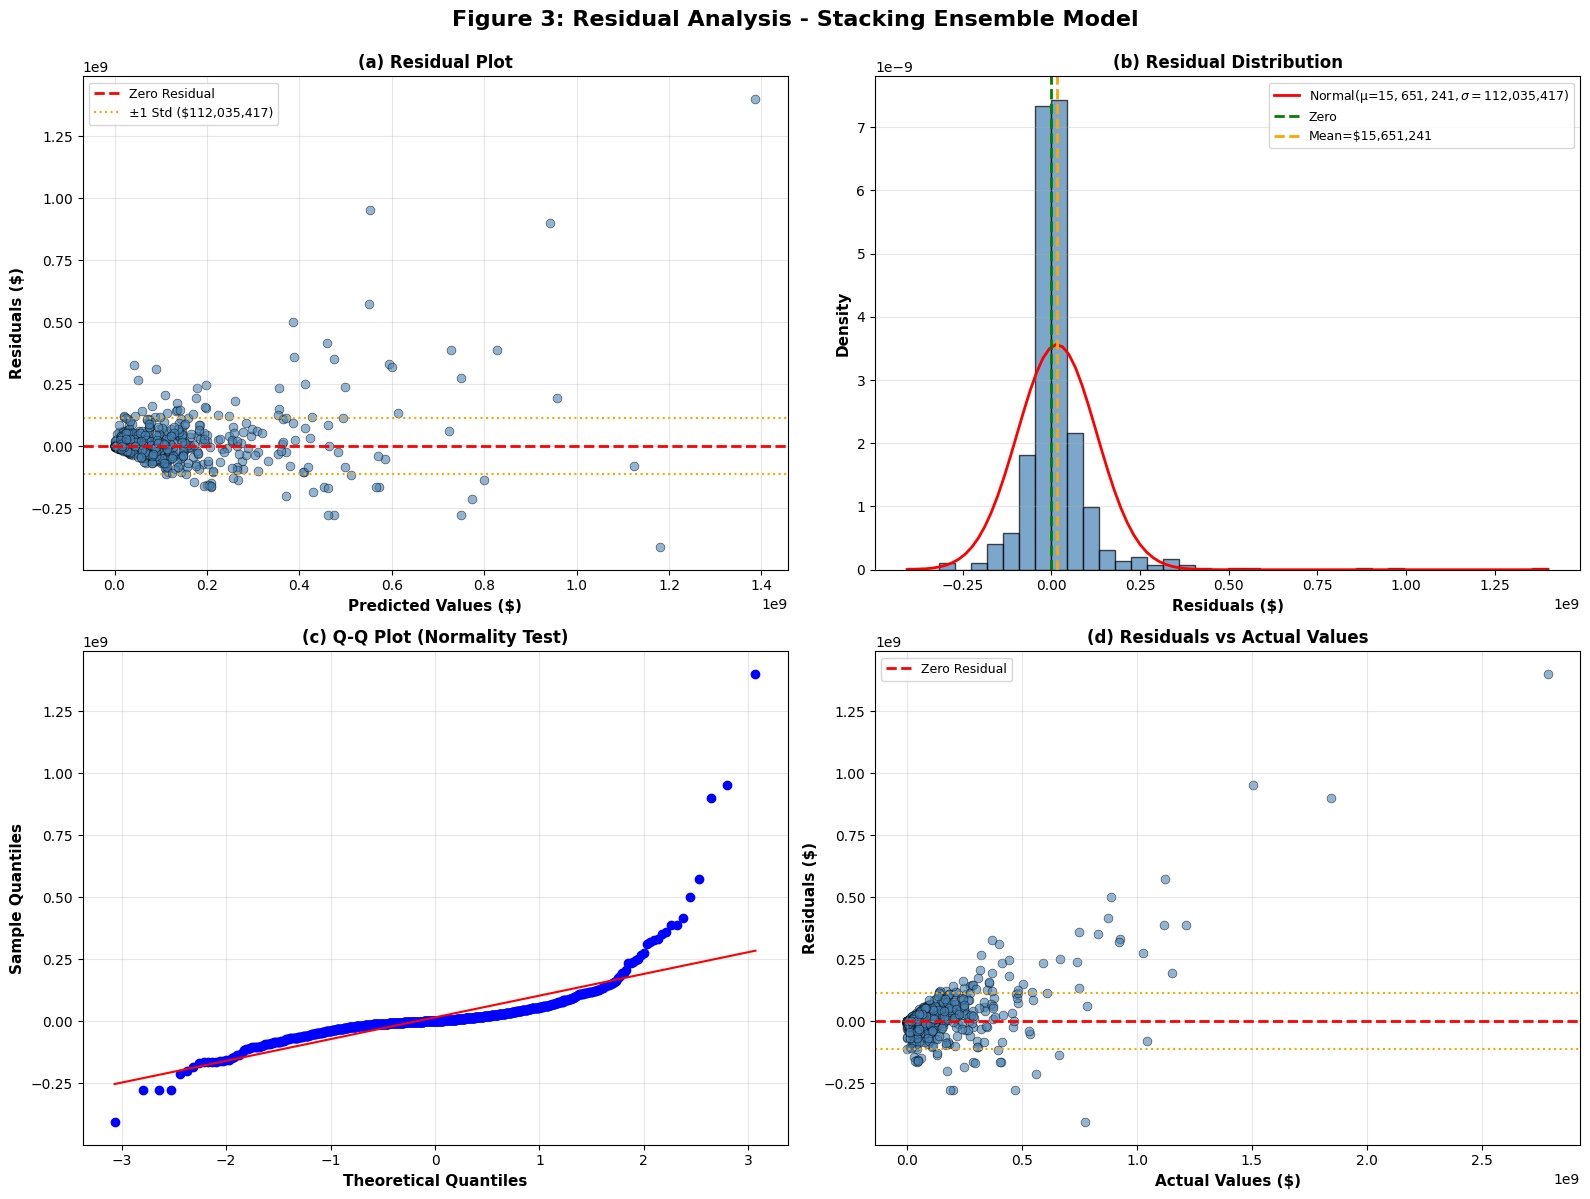

In [166]:
residuals_stack = y_test - y_test_pred_stack

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Figure 3: Residual Analysis - Stacking Ensemble Model', 
             fontsize=16, fontweight='bold', y=0.995)

# Subplot 1: Residuals vs Predicted
ax1 = axes[0, 0]
scatter = ax1.scatter(y_test_pred_stack, residuals_stack, alpha=0.6, s=40, 
                     c='steelblue', edgecolors='black', linewidth=0.5)
ax1.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Residual')
ax1.axhline(y=residuals_stack.std(), color='orange', linestyle=':', lw=1.5, 
           label=f'±1 Std (${residuals_stack.std():,.0f})')
ax1.axhline(y=-residuals_stack.std(), color='orange', linestyle=':', lw=1.5)
ax1.set_xlabel('Predicted Values ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
ax1.set_title('(a) Residual Plot', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Residual Distribution
ax2 = axes[0, 1]
n, bins, patches = ax2.hist(residuals_stack, bins=40, edgecolor='black', 
                            alpha=0.7, color='steelblue', density=True)

mu, std = residuals_stack.mean(), residuals_stack.std()
x = np.linspace(residuals_stack.min(), residuals_stack.max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, 
        label=f'Normal(μ=${mu:,.0f}, σ=${std:,.0f})')

ax2.axvline(x=0, color='green', linestyle='--', lw=2, label='Zero')
ax2.axvline(x=mu, color='orange', linestyle='--', lw=2, label=f'Mean=${mu:,.0f}')
ax2.set_xlabel('Residuals ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Density', fontsize=11, fontweight='bold')
ax2.set_title('(b) Residual Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Q-Q Plot
ax3 = axes[1, 0]
stats.probplot(residuals_stack, dist="norm", plot=ax3)
ax3.set_title('(c) Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Theoretical Quantiles', fontsize=11, fontweight='bold')
ax3.set_ylabel('Sample Quantiles', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Subplot 4: Residuals vs Actual
ax4 = axes[1, 1]
scatter = ax4.scatter(y_test, residuals_stack, alpha=0.6, s=40, 
                     c='steelblue', edgecolors='black', linewidth=0.5)
ax4.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Residual')
ax4.axhline(y=residuals_stack.std(), color='orange', linestyle=':', lw=1.5)
ax4.axhline(y=-residuals_stack.std(), color='orange', linestyle=':', lw=1.5)
ax4.set_xlabel('Actual Values ($)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
ax4.set_title('(d) Residuals vs Actual Values', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

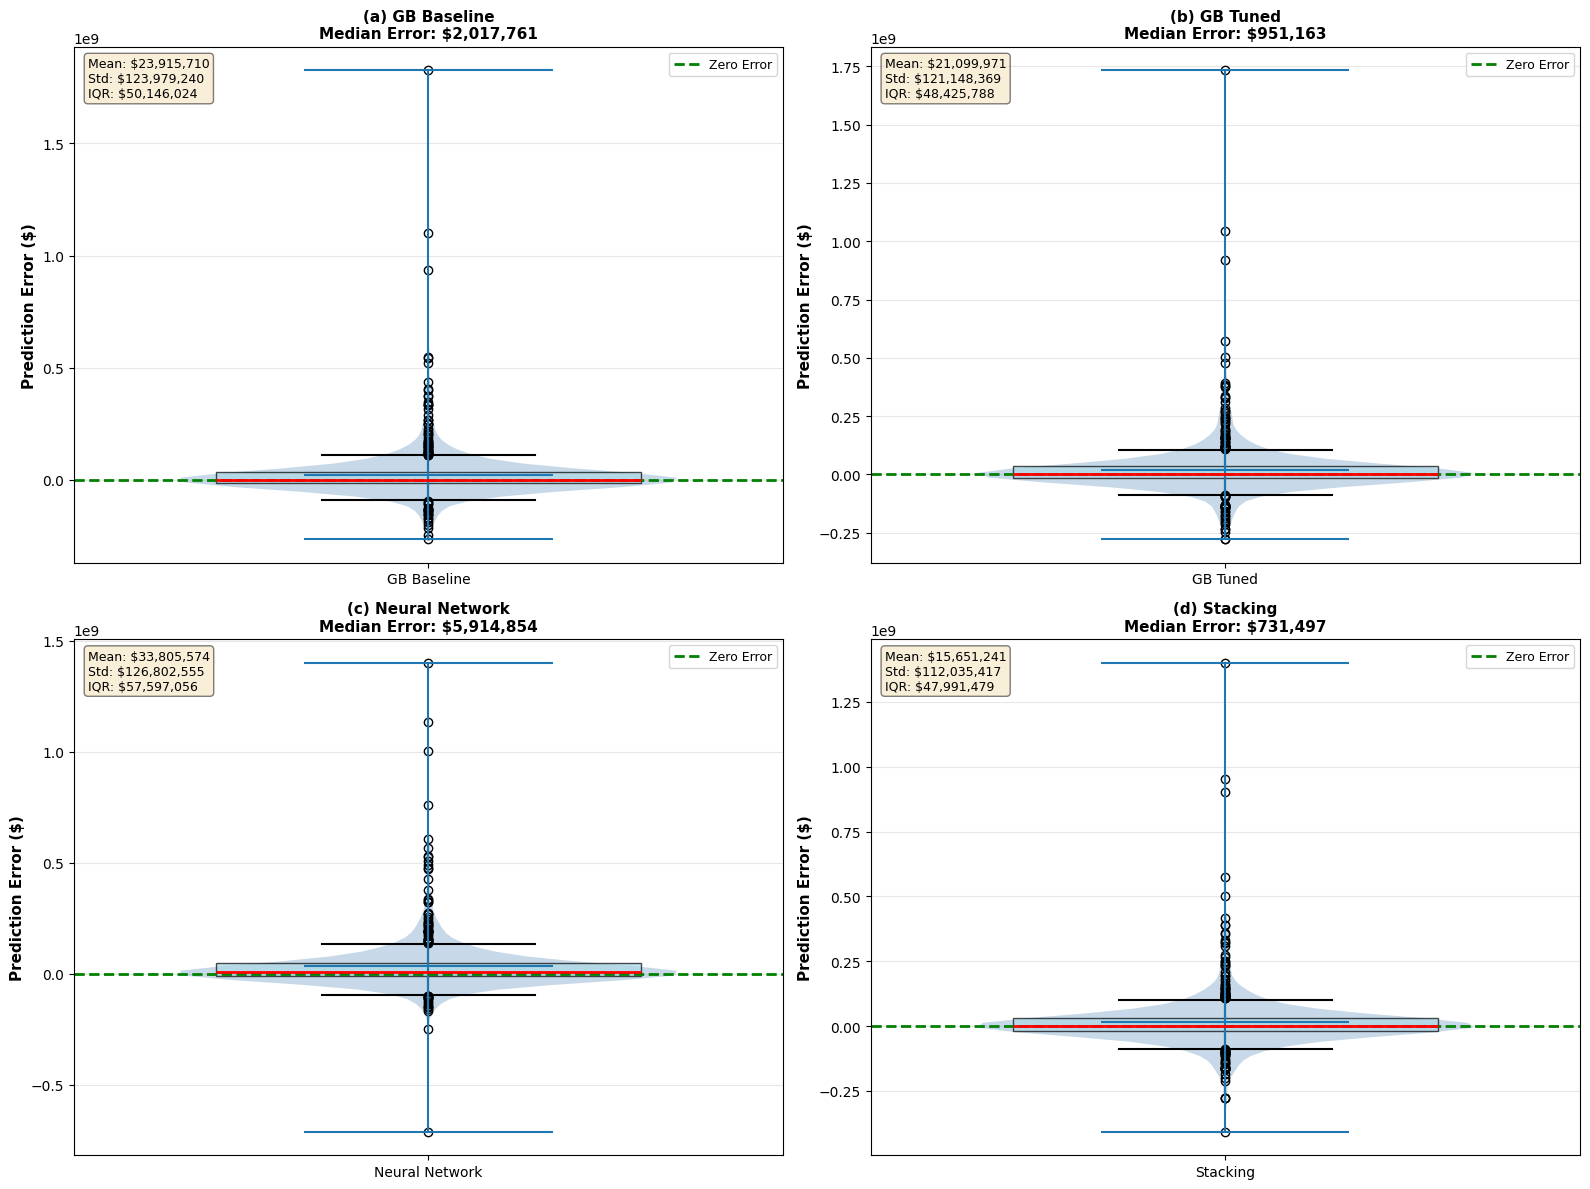

In [174]:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    models_for_errors = [
        ('GB Baseline', y_test_pred_gb),
        ('GB Tuned', y_test_pred_tuned),
        ('Neural Network', y_test_pred_nn),
        ('Stacking', y_test_pred_stack)
    ]
    
    for idx, (name, predictions) in enumerate(models_for_errors):
        ax = axes[idx // 2, idx % 2]
        
        errors = y_test - predictions
        percentage_errors = (errors / y_test) * 100
        
        # Box plot
        bp = ax.boxplot([errors], labels=[name], patch_artist=True, widths=0.6,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        parts = ax.violinplot([errors], positions=[1], widths=0.7, 
                              showmeans=True, showmedians=False)
        for pc in parts['bodies']:
            pc.set_facecolor('steelblue')
            pc.set_alpha(0.3)
        
        ax.axhline(y=0, color='green', linestyle='--', linewidth=2, label='Zero Error')
        ax.set_ylabel('Prediction Error ($)', fontsize=11, fontweight='bold')
        ax.set_title(f'({chr(97+idx)}) {name}\nMedian Error: ${np.median(errors):,.0f}', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(fontsize=9)
        
        stats_text = f'Mean: ${errors.mean():,.0f}\nStd: ${errors.std():,.0f}\nIQR: ${np.percentile(errors, 75) - np.percentile(errors, 25):,.0f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()